# IGF signaling pathway simulations

In [3]:
# Load packages
from MScausality.causal_model.LVM import LVM
from MScausality.simulation.simulation import simulate_data

import pyro
import pandas as pd
import numpy as np
from sklearn import linear_model

import networkx as nx
import y0
from y0.algorithm.simplify_latent import simplify_latent_dag
from y0.algorithm.identify import Identification, identify
from y0.dsl import P, Variable

import pickle
import copy

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Build network

In [6]:
def build_igf_network(cell_confounder):
    """
    Create IGF graph in networkx
    
    cell_confounder : bool
        Whether to add in cell type as a confounder
    """
    graph = nx.DiGraph()

    ## Add edges
    graph.add_edge("EGF", "SOS")
    graph.add_edge("EGF", "PI3K")
    graph.add_edge("IGF", "SOS")
    graph.add_edge("IGF", "PI3K")
    graph.add_edge("SOS", "Ras")
    graph.add_edge("Ras", "PI3K")
    graph.add_edge("Ras", "Raf")
    graph.add_edge("PI3K", "Akt")
    graph.add_edge("Akt", "Raf")
    graph.add_edge("Raf", "Mek")
    graph.add_edge("Mek", "Erk")
    
    if cell_confounder:
        graph.add_edge("cell_type", "Ras")
        graph.add_edge("cell_type", "Raf")
        graph.add_edge("cell_type", "Mek")
        graph.add_edge("cell_type", "Erk")
    
    return graph

def build_admg(graph, cell_confounder=False, cell_latent=False):
    ## Define obs vs latent nodes
    all_nodes = ["SOS", "PI3K", "Ras", "Raf", "Akt", 
                 "Mek", "Erk", "EGF", "IGF"]
    obs_nodes = ["SOS", "PI3K", "Ras", "Raf", "Akt", 
                 "Mek", "Erk"]
    latent_nodes = ["EGF", "IGF"]
    
    ## Add in cell_type if included
    if cell_confounder:
        all_nodes.append("cell_type")
        if cell_latent:
            latent_nodes.append("cell_type")
        else:
            obs_nodes.append("cell_type")
        
    attrs = {node: (True if node not in obs_nodes and 
                    node != "\\n" else False) for node in all_nodes}

    nx.set_node_attributes(graph, attrs, name="hidden")
    
    ## Use y0 to build ADMG
    # simplified_graph = simplify_latent_dag(graph.copy(), "hidden")
    y0_graph = y0.graph.NxMixedGraph()
    y0_graph = y0_graph.from_latent_variable_dag(graph, "hidden")
    
    return y0_graph

In [7]:
cell_type_graph = build_igf_network(cell_confounder=True)
bulk_graph = build_igf_network(cell_confounder=False)
y0_graph_bulk = build_admg(bulk_graph, cell_confounder=False)

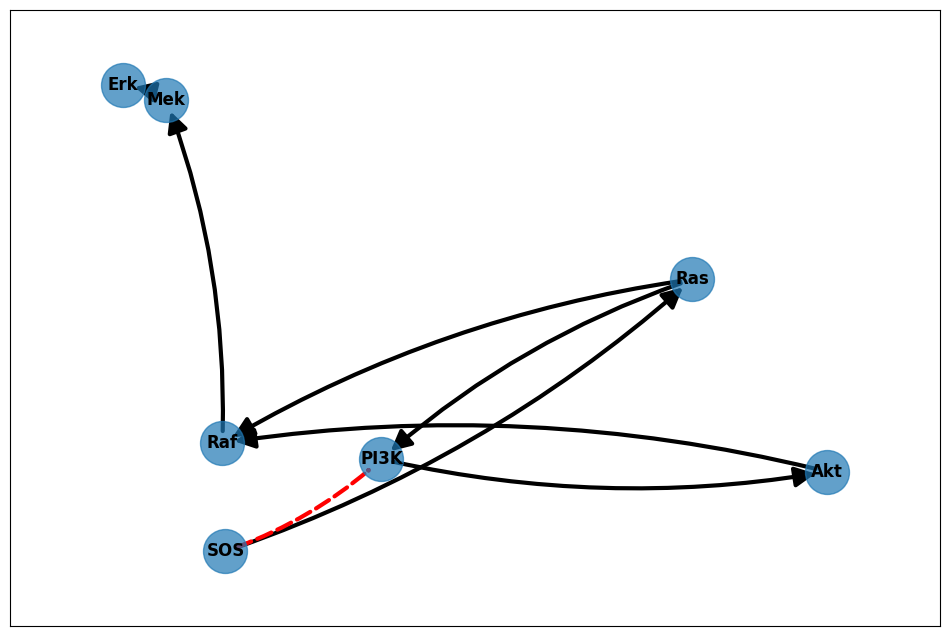

In [8]:
def plot_latent_graph(y0_graph, figure_size=(4, 3), title=None):

    ## Create new graph and specify color and shape of observed vs latent edges
    temp_g = nx.DiGraph()

    for d_edge in list(y0_graph.directed.edges):
        temp_g.add_edge(d_edge[0], d_edge[1], color="black", style='-', size=30)
    for u_edge in list(y0_graph.undirected.edges):
        if temp_g.has_edge(u_edge[0], u_edge[1]):
            temp_g.add_edge(u_edge[1], u_edge[0], color="red", style='--', size=1)
        else:
            temp_g.add_edge(u_edge[0], u_edge[1], color="red", style='--', size=1)

    ## Extract edge attributes
    pos = nx.random_layout(temp_g)
    edges = temp_g.edges()
    colors = [temp_g[u][v]['color'] for u, v in edges]
    styles = [temp_g[u][v]['style'] for u, v in edges]
    arrowsizes = [temp_g[u][v]['size'] for u, v in edges]

    ## Plot
    fig, ax = plt.subplots(figsize=figure_size)
    nx.draw_networkx_nodes(temp_g, pos=pos, node_size=1000, margins=[.1, .1], alpha=.7)
    nx.draw_networkx_labels(temp_g, pos=pos, font_weight='bold')
    nx.draw_networkx_edges(temp_g, pos=pos, ax=ax, connectionstyle='arc3, rad = 0.1',
                           edge_color=colors, width=3, style=styles, arrowsize=arrowsizes)
    if title is not None:
        ax.set_title(title)
    plt.show()
    
plot_latent_graph(y0_graph_bulk, figure_size=(12, 8))

## Ground truth invervention

Generate interventional data using the ground truth network for comparison.

In [9]:
## Coefficients for relations
cell_coef = {'EGF': {'intercept': 18., "error": 3},
              'IGF': {'intercept': 17., "error": 3},
              'SOS': {'intercept': -4, "error": 1, 
                      'EGF': 0.6, 'IGF': 0.6,},
              'Ras': {'intercept': 5, "error": 1, 'SOS': .5, "cell_type" : [3, 0, -3]},
              'PI3K': {'intercept': 1.6, "error": 1, 
                       'EGF': .5, 'IGF': 0.5, 'Ras': .5,},
              'Akt': {'intercept': 2., "error": 1, 'PI3K': 0.75, },
              'Raf': {'intercept': 2, "error": 1,
                      'Ras': 0.8, 'Akt': -.4, "cell_type" : [-2, 0, 2]},
              'Mek': {'intercept': 3., "error": 1, 'Raf': 0.75, "cell_type" : [-2, 0, 2]},
              'Erk': {'intercept': 4., "error": 1, 'Mek': 1.2, "cell_type" : [-2, 0, 2]}
             }

In [10]:
def obs_gt_sim(coef, n, cell_type, n_cells=1):
    
    """
    Observational ground truth simulation of network
    """
    
    if cell_type:
        cell_type = np.repeat([i for i in range(n_cells)], n//n_cells)
        if len(cell_type) < n:
            cell_type = np.append(cell_type, n_cells-1)
            
    EGF = np.random.normal(coef["EGF"]["intercept"], 3, n)
    IGF = np.random.normal(coef["IGF"]["intercept"], 3, n)

    SOS = coef["SOS"]["intercept"] + coef["SOS"]["EGF"]*EGF + coef["SOS"]["IGF"]*IGF + np.random.normal(0, 1., n)
    Ras = coef["Ras"]["intercept"] + coef["Ras"]["SOS"]*SOS + np.array(coef["Ras"]["cell_type"])[cell_type] + np.random.normal(0, 1., n)
    PI3K = coef["PI3K"]["intercept"] + coef["PI3K"]["Ras"]*Ras + coef["PI3K"]["EGF"]*EGF + coef["PI3K"]["IGF"]*IGF + np.random.normal(0, 1., n)
    Akt = coef["Akt"]["intercept"] + coef["Akt"]["PI3K"]*PI3K + np.random.normal(0, 1., n)
    Raf = coef["Raf"]["intercept"] + coef["Raf"]["Ras"]*Ras + coef["Raf"]["Akt"]*Akt + np.array(coef["Raf"]["cell_type"])[cell_type] + np.random.normal(0, 1., n)
    Mek = coef["Mek"]["intercept"] + coef["Mek"]["Raf"]*Raf + np.array(coef["Mek"]["cell_type"])[cell_type] + np.random.normal(0, 1., n)
    Erk = coef["Erk"]["intercept"] + coef["Erk"]["Mek"]*Mek + np.array(coef["Erk"]["cell_type"])[cell_type] + np.random.normal(0, 1., n)
    
    return({"EGF" : EGF, "IGF" : IGF, "SOS" : SOS, 
            "Ras" : Ras, "PI3K": PI3K, "Akt" : Akt,
            "Raf" : Raf, "Mek" : Mek, "Erk" : Erk, "cell_type" : cell_type})

def int_gt_sim(coef, n, inc_cell_type, n_cells=1):

    """
    Ras interventional simulation of network (Ras=10 vs Ras=20)
    """
    
    if inc_cell_type:
        cell_type = np.repeat([i for i in range(n_cells)], n//n_cells)
        if len(cell_type) < n:
            cell_type = np.append(cell_type, n_cells-1)
            
    EGF = np.random.normal(coef["EGF"]["intercept"], 3, n)
    IGF = np.random.normal(coef["IGF"]["intercept"], 3, n)

    SOS = coef["SOS"]["intercept"] + coef["SOS"]["EGF"]*EGF + coef["SOS"]["IGF"]*IGF + np.random.normal(0, 1., n)
    Ras = 10
    PI3K = coef["PI3K"]["intercept"] + coef["PI3K"]["Ras"]*Ras + coef["PI3K"]["EGF"]*EGF + coef["PI3K"]["IGF"]*IGF + np.random.normal(0, 1., n)
    Akt = coef["Akt"]["intercept"] + coef["Akt"]["PI3K"]*PI3K + np.random.normal(0, 1., n)
    Raf = coef["Raf"]["intercept"] + coef["Raf"]["Ras"]*Ras + coef["Raf"]["Akt"]*Akt + np.array(coef["Raf"]["cell_type"])[cell_type] + np.random.normal(0, 1., n)
    Mek = coef["Mek"]["intercept"] + coef["Mek"]["Raf"]*Raf + np.array(coef["Mek"]["cell_type"])[cell_type] + np.random.normal(0, 1., n)
    Erk10 = coef["Erk"]["intercept"] + coef["Erk"]["Mek"]*Mek + np.array(coef["Erk"]["cell_type"])[cell_type] + np.random.normal(0, 1., n)
    
    EGF = np.random.normal(coef["EGF"]["intercept"], 5, n)
    IGF = np.random.normal(coef["IGF"]["intercept"], 5, n)

    SOS = coef["SOS"]["intercept"] + coef["SOS"]["EGF"]*EGF + coef["SOS"]["IGF"]*IGF + np.random.normal(0, 1., n)
    Ras = 20
    PI3K = coef["PI3K"]["intercept"] + coef["PI3K"]["Ras"]*Ras + coef["PI3K"]["EGF"]*EGF + coef["PI3K"]["IGF"]*IGF + np.random.normal(0, 1., n)
    Akt = coef["Akt"]["intercept"] + coef["Akt"]["PI3K"]*PI3K + np.random.normal(0, 1., n)
    Raf = coef["Raf"]["intercept"] + coef["Raf"]["Ras"]*Ras + coef["Raf"]["Akt"]*Akt + np.array(coef["Raf"]["cell_type"])[cell_type] + np.random.normal(0, 1., n)
    Mek = coef["Mek"]["intercept"] + coef["Mek"]["Raf"]*Raf + np.array(coef["Mek"]["cell_type"])[cell_type] + np.random.normal(0, 1., n)
    Erk20 = coef["Erk"]["intercept"] + coef["Erk"]["Mek"]*Mek + np.array(coef["Erk"]["cell_type"])[cell_type] + np.random.normal(0, 1., n)
    
    int_data = [Erk10, Erk20]
    if inc_cell_type:
        int_data.append(cell_type)
        
    return int_data

gt_int_cell = int_gt_sim(cell_coef, 100000, inc_cell_type=True, n_cells=3)

(-5.0, 30.0)

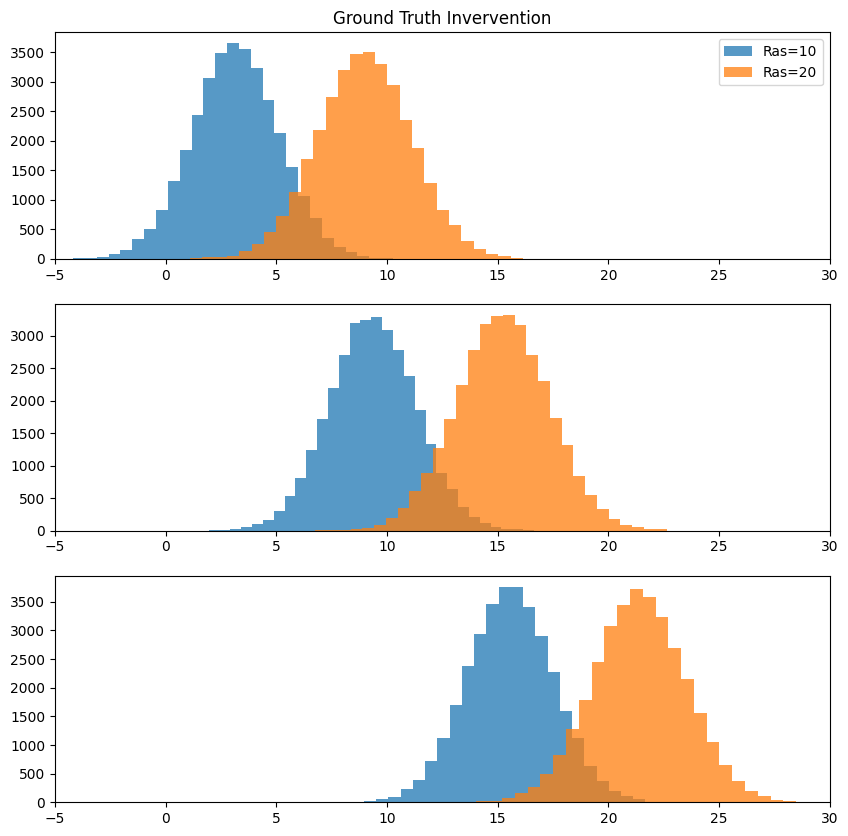

In [11]:
fig, ax = plt.subplots(3,1,figsize=(10,10))

ax[0].hist(gt_int_cell[0][gt_int_cell[2] == 0], label="Ras=10", alpha=.75, bins=30)
ax[0].hist(gt_int_cell[1][gt_int_cell[2] == 0], label="Ras=20", alpha=.75, bins=30)
ax[0].legend()
ax[1].hist(gt_int_cell[0][gt_int_cell[2] == 1], label="Ras=10", alpha=.75, bins=30)
ax[1].hist(gt_int_cell[1][gt_int_cell[2] == 1], label="Ras=20", alpha=.75, bins=30)
ax[2].hist(gt_int_cell[0][gt_int_cell[2] == 2], label="Ras=10", alpha=.75, bins=30)
ax[2].hist(gt_int_cell[1][gt_int_cell[2] == 2], label="Ras=20", alpha=.75, bins=30)

ax[0].set_title("Ground Truth Invervention")
ax[0].set_xlim(-5, 30)
ax[1].set_xlim(-5, 30)
ax[2].set_xlim(-5, 30)

In [12]:
np.mean(gt_int_cell[1][gt_int_cell[2] == 0]) - np.mean(gt_int_cell[0][gt_int_cell[2] == 0])

5.838769967839678

In [13]:
np.mean(gt_int_cell[1][gt_int_cell[2] == 1]) - np.mean(gt_int_cell[0][gt_int_cell[2] == 1])

5.874553108307143

In [14]:
np.mean(gt_int_cell[1][gt_int_cell[2] == 2]) - np.mean(gt_int_cell[0][gt_int_cell[2] == 2])

5.846660029075995

(array([   0.,  500., 1000., 1500., 2000., 2500., 3000., 3500.]),
 [Text(0, 0.0, '0'),
  Text(0, 500.0, '500'),
  Text(0, 1000.0, '1000'),
  Text(0, 1500.0, '1500'),
  Text(0, 2000.0, '2000'),
  Text(0, 2500.0, '2500'),
  Text(0, 3000.0, '3000'),
  Text(0, 3500.0, '3500')])

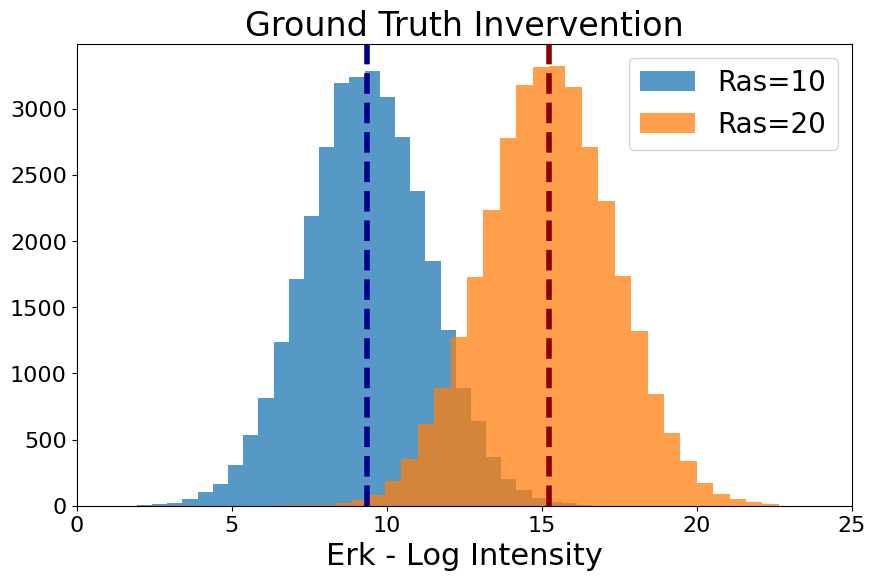

In [15]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(gt_int_cell[0][gt_int_cell[2] == 1], label="Ras=10", alpha=.75, bins=30)
ax.axvline(np.mean(np.array(gt_int_cell[0][gt_int_cell[2] == 1])), color="darkblue", linestyle="dashed", lw=4)
ax.hist(gt_int_cell[1][gt_int_cell[2] == 1], label="Ras=20", alpha=.75, bins=30)
ax.axvline(np.mean(np.array(gt_int_cell[1][gt_int_cell[2] == 1])), color="darkred", linestyle="dashed", lw=4)
ax.legend(fontsize=20)

ax.set_title("Ground Truth Invervention", size=24)
ax.set_xlim(0, 25)
ax.set_xlabel("Erk - Log Intensity", size=22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

## Cell Type - Bulk

### Simulate Data

In [16]:
cell_sim = simulate_data(bulk_graph, coefficients=cell_coef, include_missing=True, 
                         cell_type=True, n_cells=3, n=300, seed=1)

simulating data...
adding feature level data...
masking data...


Save feature level data to csvs to run data processing in MSstats in R. Wrapper for dataProcess functionality is being added to MScausality but is not currently available. For information on the R code to run please see the documentation for the dataProcess.py function (i.e., ?dataProcess)

In [9]:
?dataProcess

Signature: dataProcess(data, normalization='equalizeMedians', MBimpute=True)
Docstring:
Implementation of MSstats dataProcess function in Python.

Currently unavailable, to convert simualated data into MSstats format and run dataProcess function,
execute the following code in R:

library(MSstats)
library(tidyverse)

data = read.csv("sim_feature_level_data.csv")
data = data %>% select(Protein, Feature, Replicate, Obs_Intensity)
data = data %>% rename(ProteinName=Protein, PeptideSequence=Feature,
                       BioReplicate=Replicate, Intensity=Obs_Intensity)

data$PrecursorCharge = 2
data$FragmentIon = NA
data$ProductCharge= NA
data$IsotopeLabelType = "L"
data$Condition = "Obs"
data$Run = data$BioReplicate
data$Fraction = 1
data$PeptideSequence  = paste(data$ProteinName, data$PeptideSequence , sep="_")
data$Run = paste(data$Run, data$Condition, sep="_")
data$Intensity = 2**data$Intensity

processed_data = dataProcess(data, normalization="equalizeMedians", MBimpute=TRUE)
processe

In [111]:
cell_sim["Feature_data"].to_csv("../data/IGF_pathway/cell_type_feature_data.csv", index=False)

In [18]:
cell_sim_protein_data = pd.read_csv("../../data/IGF_pathway/cell_type_protein_data.csv")
cell_sim_protein_data.loc[:, "cell_type"] = cell_sim["Protein_data"]["cell_type"].astype(str)

### Initial Analysis

(array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 [Text(0, 2.0, '2'),
  Text(0, 3.0, '3'),
  Text(0, 4.0, '4'),
  Text(0, 5.0, '5'),
  Text(0, 6.0, '6'),
  Text(0, 7.0, '7'),
  Text(0, 8.0, '8'),
  Text(0, 9.0, '9'),
  Text(0, 10.0, '10'),
  Text(0, 11.0, '11')])

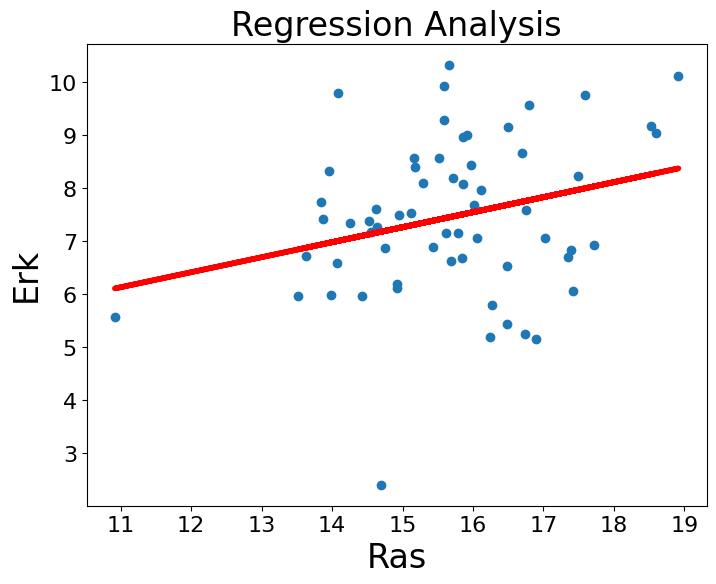

In [19]:
fig, ax = plt.subplots(figsize=(8,6))

plot_data = cell_sim_protein_data.dropna()
x = plot_data[plot_data["cell_type"] == "0"]["Ras"]
y = plot_data[plot_data["cell_type"] == "0"]["Erk"]

ax.scatter(x, y)
m, b = np.polyfit(x.values, y.values, 1)
ax.plot(x, m*x + b, color="red", lw=4)

ax.set_title("Regression Analysis", size=24)
ax.set_xlabel("Ras", size=24)
ax.set_ylabel("Erk", size=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

(array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5]),
 [Text(0, 0.0, '0.0'),
  Text(0, 2.5, '2.5'),
  Text(0, 5.0, '5.0'),
  Text(0, 7.5, '7.5'),
  Text(0, 10.0, '10.0'),
  Text(0, 12.5, '12.5'),
  Text(0, 15.0, '15.0'),
  Text(0, 17.5, '17.5'),
  Text(0, 20.0, '20.0'),
  Text(0, 22.5, '22.5')])

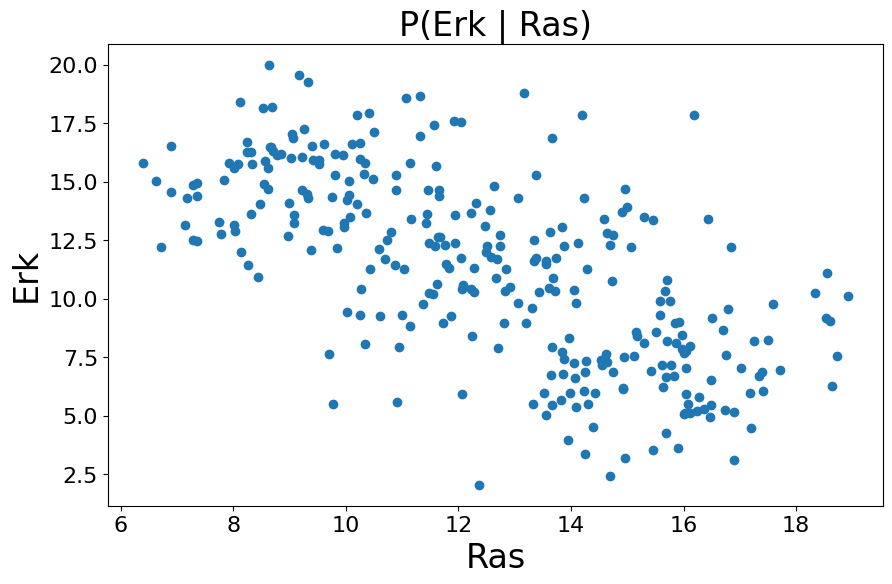

In [20]:
fig, ax = plt.subplots(figsize=(10,6))

x = cell_sim_protein_data["Ras"]
y = cell_sim_protein_data["Erk"]

ax.scatter(x, y)

ax.set_title("P(Erk | Ras)", size=24)
ax.set_xlabel("Ras", size=24)
ax.set_ylabel("Erk", size=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

### Run inference

In [34]:
lvm = LVM(cell_sim_protein_data.iloc[:,1:-1], 
          y0_graph_bulk)
lvm.prepare_graph()
lvm.prepare_data()
lvm.fit_model(num_steps=2000)

lvm.intervention("Ras", "Erk", 10)
first_int = lvm.intervention_samples

lvm.intervention("Ras", "Erk", 20)
second_int = lvm.intervention_samples

starting training
-1391.8485361412168


-2181.1107438039035
-2587.5168652758002
-2859.0185853280127
-3082.3236185908318
-3206.440627988428
-3299.573931284249
-3334.2024557627738
-3457.00427801162
-3429.6601139009
-3496.7983328402042
-3537.5186889991164
-3587.61954321526
-3548.962201565504
-3549.116605486721
-3610.036969784647
-3631.7162847416475
-3653.2659403048456
-3701.284697874915
-3632.0770857417956


In [36]:
lvm.parameters

,parameter,mean,scale
0,SOS_intercept,16.998459,0.11779032
1,SOS_scale,0.6787616,0.040281724
2,Ras_intercept,0.87898743,0.14907995
3,Ras_SOS_coef,0.6615461,0.008444351
4,Ras_scale,0.94611984,0.039859243
5,PI3K_intercept,13.483726,0.09204073
6,PI3K_Ras_coef,0.98117054,0.006865408
7,PI3K_scale,0.41316798,0.041473296
8,Akt_intercept,1.0910796,0.05721789
9,Akt_PI3K_coef,0.784435,0.002179709


In [37]:
np.mean(np.array(second_int)) - np.mean(np.array(first_int))

1.8198919

(-5.0, 40.0)

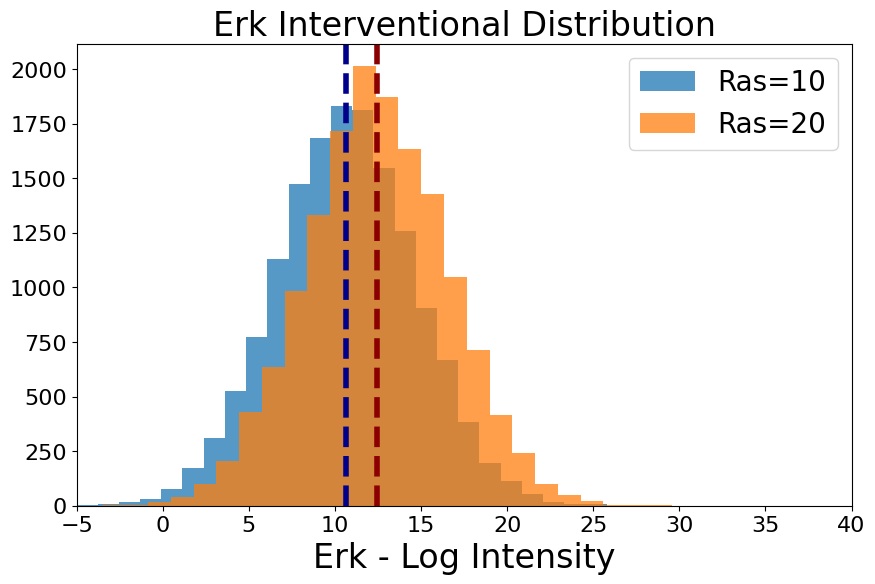

In [38]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(np.array(first_int), bins=25, alpha=.75, label="Ras=10")
ax.axvline(np.mean(np.array(first_int)), color="darkblue", linestyle="dashed", lw=4)
ax.hist(np.array(second_int), bins=25, alpha=.75, label="Ras=20")
ax.axvline(np.mean(np.array(second_int)), color="darkred", linestyle="dashed", lw=4)

ax.legend(fontsize=20)
ax.set_title("Erk Interventional Distribution", size=24)
ax.set_xlabel("Erk - Log Intensity", size=24)
# ax.set_ylabel("Erk", size=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax.set_xlim(-5,40)

## Cell Type - Single cell

### Analysis

In [28]:
single_cell_lm = linear_model.LinearRegression()

fit_data = pd.concat([cell_sim_protein_data[["Ras", "Erk"]], 
               pd.get_dummies(cell_sim_protein_data["cell_type"].values)], 
              axis=1).dropna()
x = fit_data.drop(columns=["Erk"])
y = fit_data["Erk"]
single_cell_lm.fit(x, y)

bulk_lm = linear_model.LinearRegression()
x = cell_sim_protein_data.dropna()[["Ras"]]
y = cell_sim_protein_data.dropna()[["Erk"]]
bulk_lm.fit(x, y)

LinearRegression()

Text(0, 0.5, 'Erk')

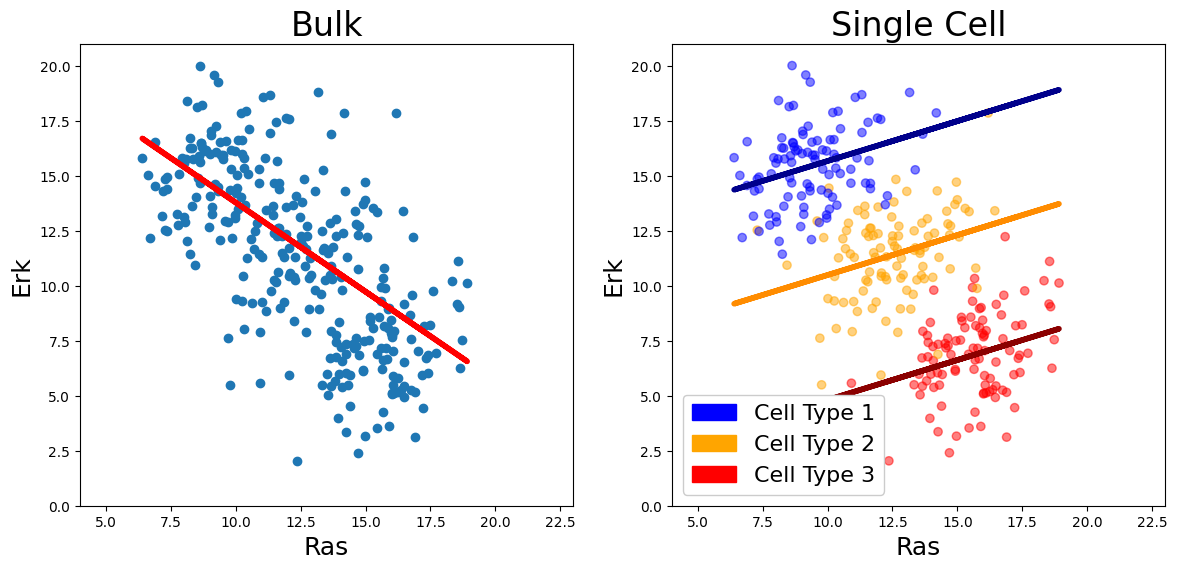

In [29]:
## Plot
fig, ax = plt.subplots(1, 2, figsize=(14,6))

colors = np.where(cell_sim_protein_data["cell_type"] == "0", "Red", 
                  np.where(cell_sim_protein_data["cell_type"] == "1", "Orange", "Blue"))

ax[0].scatter(cell_sim_protein_data["Ras"], cell_sim_protein_data["Erk"])
ax[1].scatter(cell_sim_protein_data["Ras"], cell_sim_protein_data["Erk"], 
              c=colors, alpha=.5)

ax[0].plot(cell_sim_protein_data["Ras"], 
           bulk_lm.coef_[0]*cell_sim_protein_data["Ras"] + bulk_lm.intercept_[0], 
           color="red", lw=4)
ax[1].plot(cell_sim_protein_data["Ras"], 
           single_cell_lm.coef_[0]*cell_sim_protein_data["Ras"] + \
           single_cell_lm.intercept_ + single_cell_lm.coef_[1], 
           color="darkred", lw=4)
ax[1].plot(cell_sim_protein_data["Ras"], 
           single_cell_lm.coef_[0]*cell_sim_protein_data["Ras"] + \
           single_cell_lm.intercept_ + single_cell_lm.coef_[2], 
           color="darkOrange", lw=4)
ax[1].plot(cell_sim_protein_data["Ras"], 
           single_cell_lm.coef_[0]*cell_sim_protein_data["Ras"] + \
           single_cell_lm.intercept_ + single_cell_lm.coef_[3], 
           color="darkBlue", lw=4)

red_patch = mpatches.Patch(color='red', label='Cell Type 3')
orange_patch = mpatches.Patch(color='orange', label='Cell Type 2')
blue_patch = mpatches.Patch(color='blue', label='Cell Type 1')

ax[1].legend(handles=[blue_patch, orange_patch, red_patch], fontsize=16, loc="lower left", framealpha=1.)

ax[0].set_xlim(4,23)
ax[1].set_xlim(4,23)
ax[0].set_ylim(0,21)
ax[1].set_ylim(0,21)

ax[0].set_title("Bulk", fontsize=24)
ax[1].set_title("Single Cell", fontsize=24)

ax[0].set_xlabel("Ras", fontsize=18)
ax[1].set_xlabel("Ras", fontsize=18)

ax[0].set_ylabel("Erk", fontsize=18)
ax[1].set_ylabel("Erk", fontsize=18)

# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)

### Run inference

In [50]:
datasets = {"Cell1" : cell_sim_protein_data[cell_sim_protein_data["cell_type"] == "0"].iloc[:,1:-1].reset_index(drop=True), 
            "Cell2" : cell_sim_protein_data[cell_sim_protein_data["cell_type"] == "1"].iloc[:,1:-1].reset_index(drop=True),
            "Cell3" : cell_sim_protein_data[cell_sim_protein_data["cell_type"] == "2"].iloc[:,1:-1].reset_index(drop=True)}

intervention_results = dict()

for name, data in datasets.items():
    pyro.clear_param_store()
    lvm = LVM(data, y0_graph_bulk)
    lvm.prepare_graph()
    lvm.prepare_data()
    lvm.fit_model(num_steps=4000)
    
    lvm.intervention("Ras", "Erk", 10)
    first_int = lvm.intervention_samples
    
    lvm.intervention("Ras", "Erk", 20)
    second_int = lvm.intervention_samples
    
    intervention_results[name] = [first_int, second_int, lvm]

starting training
83944.71402535588
977.4751296043396
210.00138806551695
-55.54429815709591
-240.49085379764438
-296.88149074465036
-454.5723410695791
-518.7043964751065
-555.3010102659464
-613.1855071932077
-657.9930624812841
-710.3242057077587
-757.3370053190738
-748.8604367040098
-748.2170298732817
-808.0041689872742
-826.7924625463784
-827.8077148869634
-856.7683312520385
-876.1536559313536
-878.6185589469969
-931.5368898883462
-897.0950447507203
-910.1539589352906
-916.6462170481682
-911.0635607503355
-926.3844559639692
-924.8381802402437
-898.326901126653
-929.6027599163353
-940.1063347272575
-952.0998110175133
-957.5406628958881
-958.9827367290854
-956.6104806363583
-982.2340436577797
-958.4073623865843
-951.6884074509144
-975.8052192460746
-965.325099023059
starting training
88254.38093875162
1040.307288594544
137.30525048449636
-153.0908596739173
-324.0158685259521
-465.38423203118145
-596.4795889407396
-630.7502348888665
-670.6014800444245
-744.27008670941
-765.9532107096165


Text(0.5, 0, 'Erk - Log Intensity')

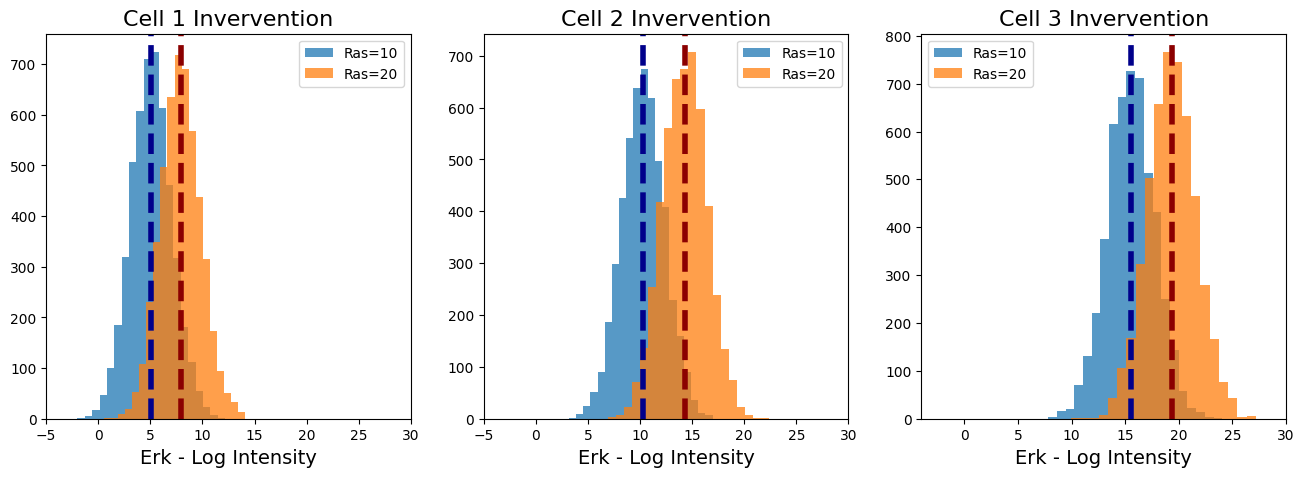

In [51]:
fig, ax = plt.subplots(1,3,figsize=(16,5))

ax[0].hist(np.array(intervention_results["Cell1"][0]), label="Ras=10", alpha=.75, bins=20)
ax[0].axvline(np.mean(np.array(intervention_results["Cell1"][0])), color="darkblue", linestyle="dashed", lw=4)
ax[0].hist(np.array(intervention_results["Cell1"][1]), label="Ras=20", alpha=.75, bins=20)
ax[0].axvline(np.mean(np.array(intervention_results["Cell1"][1])), color="darkred", linestyle="dashed", lw=4)
ax[0].legend()

ax[1].hist(np.array(intervention_results["Cell2"][0]), label="Ras=10", alpha=.75, bins=20)
ax[1].axvline(np.mean(np.array(intervention_results["Cell2"][0])), color="darkblue", linestyle="dashed", lw=4)
ax[1].hist(np.array(intervention_results["Cell2"][1]), label="Ras=20", alpha=.75, bins=20)
ax[1].axvline(np.mean(np.array(intervention_results["Cell2"][1])), color="darkred", linestyle="dashed", lw=4)
ax[1].legend()

ax[2].hist(np.array(intervention_results["Cell3"][0]), label="Ras=10", alpha=.75, bins=20)
ax[2].axvline(np.mean(np.array(intervention_results["Cell3"][0])), color="darkblue", linestyle="dashed", lw=4)
ax[2].hist(np.array(intervention_results["Cell3"][1]), label="Ras=20", alpha=.75, bins=20)
ax[2].axvline(np.mean(np.array(intervention_results["Cell3"][1])), color="darkred", linestyle="dashed", lw=4)
ax[2].legend()

ax[0].set_title("Cell 1 Invervention", fontsize=16)
ax[1].set_title("Cell 2 Invervention", fontsize=16)
ax[2].set_title("Cell 3 Invervention", fontsize=16)
ax[0].set_xlim(-5, 30)
ax[1].set_xlim(-5, 30)
ax[2].set_xlim(-4, 30)
ax[0].set_xlabel("Erk - Log Intensity", size=14)
ax[1].set_xlabel("Erk - Log Intensity", size=14)
ax[2].set_xlabel("Erk - Log Intensity", size=14)
# ax.set_ylabel("Erk", size=24)

In [55]:
np.mean(np.array(intervention_results["Cell1"][1])) - np.mean(np.array(intervention_results["Cell1"][0]))

2.820404

In [56]:
np.mean(np.array(intervention_results["Cell2"][1])) - np.mean(np.array(intervention_results["Cell2"][0]))

3.9859638

In [57]:
np.mean(np.array(intervention_results["Cell3"][1])) - np.mean(np.array(intervention_results["Cell3"][0]))

3.7919397

## Low vs High Replicates

Compare causal effect estimation using different numbers of replicates.

### Simulate Data

In [58]:
low_rep_data = simulate_data(bulk_graph, coefficients=cell_coef, include_missing=True, n=10, seed=1)
med_rep_data = simulate_data(bulk_graph, coefficients=cell_coef, include_missing=True, n=50, seed=0)
high_rep_data = simulate_data(bulk_graph, coefficients=cell_coef, include_missing=True, n=250, seed=0)
very_high_rep_data = simulate_data(bulk_graph, coefficients=cell_coef, include_missing=True, n=1000, seed=0)

simulating data...
adding feature level data...
masking data...
simulating data...
adding feature level data...
masking data...
simulating data...
adding feature level data...
masking data...
simulating data...
adding feature level data...
masking data...


In [48]:
low_rep_data["Feature_data"].to_csv("../../data/IGF_pathway/low_rep_feature_data.csv", index=False)
med_rep_data["Feature_data"].to_csv("../../data/IGF_pathway/med_rep_feature_data.csv", index=False)
high_rep_data["Feature_data"].to_csv("../../data/IGF_pathway/high_rep_feature_data.csv", index=False)
very_high_rep_data["Feature_data"].to_csv("../../data/IGF_pathway/very_high_rep_feature_data.csv", index=False)

In [59]:
low_rep_protein_data = pd.read_csv("../../data/IGF_pathway/low_rep_protein_data.csv")
med_rep_protein_data = pd.read_csv("../../data/IGF_pathway/med_rep_protein_data.csv")
high_rep_protein_data = pd.read_csv("../../data/IGF_pathway/high_rep_protein_data.csv")
very_high_protein_data = pd.read_csv("../../data/IGF_pathway/very_high_rep_protein_data.csv")

### Initial Analysis

Text(0, 0.5, 'Erk')

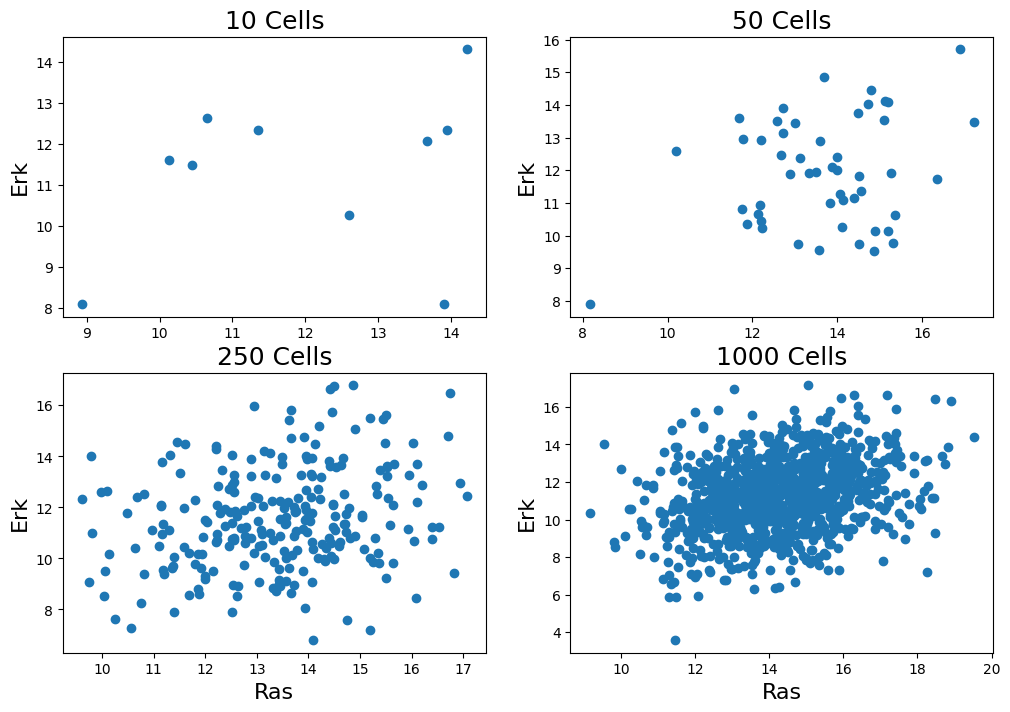

In [60]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))

ax[0,0].scatter(low_rep_protein_data["Ras"], low_rep_protein_data["Erk"])
ax[0,1].scatter(med_rep_protein_data["Ras"], med_rep_protein_data["Erk"])
ax[1,0].scatter(high_rep_protein_data["Ras"], high_rep_protein_data["Erk"])
ax[1,1].scatter(very_high_protein_data["Ras"], very_high_protein_data["Erk"])

ax[0,0].set_title("10 Cells", fontsize=18)
ax[0,1].set_title("50 Cells", fontsize=18)
ax[1,0].set_title("250 Cells", fontsize=18)
ax[1,1].set_title("1000 Cells", fontsize=18)

# ax[0,0].set_xlabel("Raf", fontsize=16)
# ax[0,1].set_xlabel("Raf", fontsize=16)
ax[1,0].set_xlabel("Ras", fontsize=16)
ax[1,1].set_xlabel("Ras", fontsize=16)

ax[0,0].set_ylabel("Erk", fontsize=16)
ax[0,1].set_ylabel("Erk", fontsize=16)
ax[1,0].set_ylabel("Erk", fontsize=16)
ax[1,1].set_ylabel("Erk", fontsize=16)

### Run inference

In [70]:
datasets = {"low" : low_rep_protein_data.iloc[:,1:], "med" : med_rep_protein_data.iloc[:,1:], 
            "high" : high_rep_protein_data.iloc[:,1:], "very_high" : very_high_protein_data.iloc[:,1:]}

intervention_results = dict()

for name, data in datasets.items():
    pyro.clear_param_store()
    lvm = LVM(data, y0_graph_bulk)
    lvm.prepare_graph()
    lvm.prepare_data()
    lvm.fit_model(num_steps=2000)
    
    lvm.intervention("Ras", "Erk", 10)
    first_int = lvm.intervention_samples
    
    lvm.intervention("Ras", "Erk", 20)
    second_int = lvm.intervention_samples
    
    intervention_results[name] = [first_int, second_int, lvm]

starting training


9129.04431980662
205.70247219502926
99.65391944348812
58.875782899558544
52.23154655098915
39.801471538841724
25.73566422611475
19.610874757170677
16.056970849633217
17.591273576021194
14.823102056980133
10.450598150491714
7.200938284397125
-5.657584685832262
-0.995753288269043
-2.935887325555086
2.0116119384765625
2.1658567786216736
0.4113837704062462
3.2769987508654594
starting training
43343.41690035979
625.0500266551971
208.5642956122756
73.76569250412285
-10.77810887992382
-33.33102913945913
-85.92069867253304
-127.31693152152002
-124.94369263015687
-134.99211283773184
-165.6006171926856
-195.44232858717442
-155.1833457313478
-181.0011260472238
-222.19105337560177
-181.19701988622546
-203.34821524471045
-198.76345052570105
-204.03227573260665
-216.65833175182343
starting training
249112.72335761553
2750.8916325867176
568.2795322053134
-257.710894247517
-665.2247631438076
-952.9546418609098
-1112.60728146974
-1311.1606994569302
-1406.6592996008694
-1478.6105481758714
-1514.12359196

### Compare to ground truth

Text(0.5, 0, 'Erk - Log Intensity')

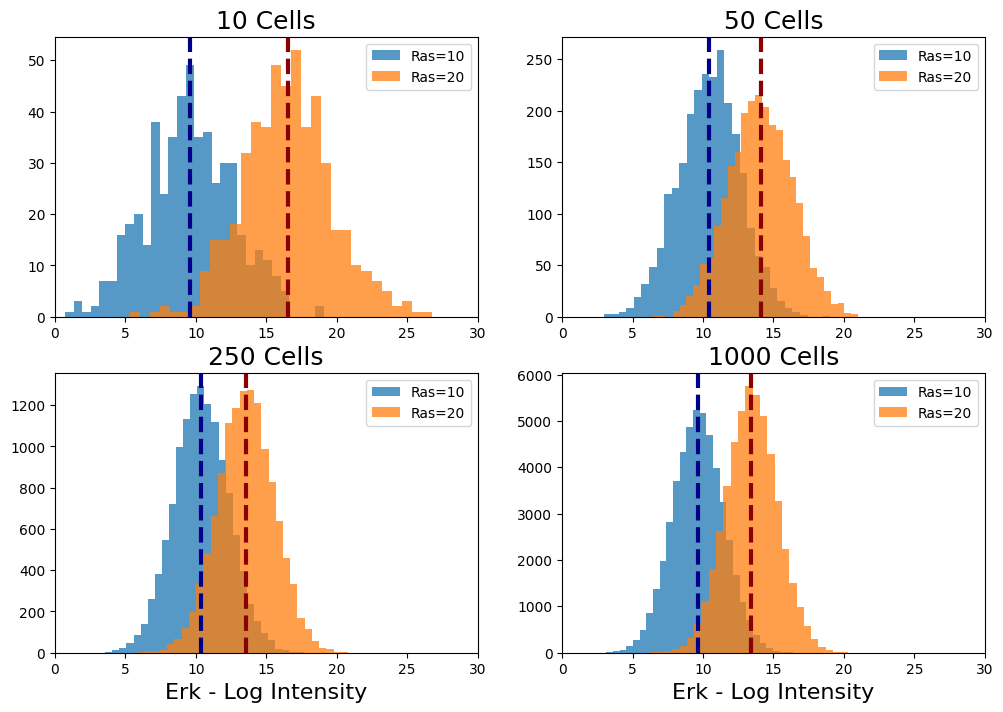

In [78]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))

ax[0,0].hist(intervention_results["low"][0], label="Ras=10", alpha=.75, bins=30)
ax[0,0].hist(intervention_results["low"][1], label="Ras=20", alpha=.75, bins=30)
ax[0,0].axvline(x=intervention_results["low"][0].mean(), color="darkblue", lw=3, linestyle="--")
ax[0,0].axvline(x=intervention_results["low"][1].mean(), color="darkred", lw=3, linestyle="--")
ax[0,0].legend()

ax[0,1].hist(intervention_results["med"][0], label="Ras=10", alpha=.75, bins=30)
ax[0,1].hist(intervention_results["med"][1], label="Ras=20", alpha=.75, bins=30)
ax[0,1].axvline(x=intervention_results["med"][0].mean(), color="darkblue", lw=3, linestyle="--")
ax[0,1].axvline(x=intervention_results["med"][1].mean(), color="darkred", lw=3, linestyle="--")
ax[0,1].legend()

ax[1,0].hist(intervention_results["high"][0], label="Ras=10", alpha=.75, bins=30)
ax[1,0].hist(intervention_results["high"][1], label="Ras=20", alpha=.75, bins=30)
ax[1,0].axvline(x=intervention_results["high"][0].mean(), color="darkblue", lw=3, linestyle="--")
ax[1,0].axvline(x=intervention_results["high"][1].mean(), color="darkred", lw=3, linestyle="--")
ax[1,0].legend()

ax[1,1].hist(intervention_results["very_high"][0], label="Ras=10", alpha=.75, bins=30)
ax[1,1].hist(intervention_results["very_high"][1], label="Ras=20", alpha=.75, bins=30)
ax[1,1].axvline(x=intervention_results["very_high"][0].mean(), color="darkblue", lw=3, linestyle="--")
ax[1,1].axvline(x=intervention_results["very_high"][1].mean(), color="darkred", lw=3, linestyle="--")
ax[1,1].legend(fontsize=20)

ax[0,0].set_xlim(0,30)
ax[0,1].set_xlim(0,30)
ax[1,0].set_xlim(0,30)
ax[1,1].set_xlim(0,30)

plt.legend()
ax[0,0].set_title("10 Cells", fontsize=18)
ax[0,1].set_title("50 Cells", fontsize=18)
ax[1,0].set_title("250 Cells", fontsize=18)
ax[1,1].set_title("1000 Cells", fontsize=18)

ax[1,0].set_xlabel("Erk - Log Intensity", size=16)
ax[1,1].set_xlabel("Erk - Log Intensity", size=16)

## Low vs High Replicates - Bulk

### Simulate data

In [21]:
low_rep_bulk_data = simulate_data(cell_type_graph, coefficients=cell_coef, include_missing=True, 
                                  cell_type=True, n_cells=3, n=30, seed=0)
med_rep_bulk_data = simulate_data(cell_type_graph, coefficients=cell_coef, include_missing=True, 
                                  cell_type=True, n_cells=3, n=100, seed=0)
high_rep_bulk_data = simulate_data(cell_type_graph, coefficients=cell_coef, include_missing=True, 
                                   cell_type=True, n_cells=3, n=250, seed=0)
very_high_rep_bulk_data = simulate_data(cell_type_graph, coefficients=cell_coef, include_missing=True, 
                                        cell_type=True, n_cells=3, n=1000, seed=1)

simulating data...
adding feature level data...


/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:200: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_level_data = pd.concat([feature_level_data, pd.DataFrame({"Protein": [node],
/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:200: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_level_data = pd.con

masking data...


/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:239: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  feature_level_data.loc[i, "MAR"] = False
/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:245: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  feature_level_data.loc[i, "MNAR"] = False


simulating data...
adding feature level data...


/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:200: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_level_data = pd.concat([feature_level_data, pd.DataFrame({"Protein": [node],
/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:200: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_level_data = pd.con

masking data...


/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:239: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  feature_level_data.loc[i, "MAR"] = False
/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:245: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  feature_level_data.loc[i, "MNAR"] = False


simulating data...
adding feature level data...


/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:200: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_level_data = pd.concat([feature_level_data, pd.DataFrame({"Protein": [node],
/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:200: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_level_data = pd.con

masking data...


/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:237: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  feature_level_data.loc[i, "MAR"] = True
/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:245: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  feature_level_data.loc[i, "MNAR"] = False


simulating data...
adding feature level data...


/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:200: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_level_data = pd.concat([feature_level_data, pd.DataFrame({"Protein": [node],
/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:200: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_level_data = pd.con

masking data...


/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:239: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  feature_level_data.loc[i, "MAR"] = False
/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:245: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  feature_level_data.loc[i, "MNAR"] = False


In [17]:
low_rep_bulk_data["Feature_data"].to_csv("../data/IGF_pathway/low_rep_bulk_feature_data.csv", index=False)
med_rep_bulk_data["Feature_data"].to_csv("../data/IGF_pathway/med_rep_bulk_feature_data.csv", index=False)
high_rep_bulk_data["Feature_data"].to_csv("../data/IGF_pathway/high_rep_bulk_feature_data.csv", index=False)
very_high_rep_bulk_data["Feature_data"].to_csv("../data/IGF_pathway/very_high_rep_bulk_feature_data.csv", index=False)

In [79]:
low_rep_bulk_protein_data = pd.read_csv("../../data/IGF_pathway/low_rep_bulk_protein_data.csv")
med_rep_bulk_protein_data = pd.read_csv("../../data/IGF_pathway/med_rep_bulk_protein_data.csv")
high_rep_bulk_protein_data = pd.read_csv("../../data/IGF_pathway/high_rep_bulk_protein_data.csv")
very_high_bulk_protein_data = pd.read_csv("../../data/IGF_pathway/very_high_rep_bulk_protein_data.csv")

### Analysis

Text(0, 0.5, 'Erk')

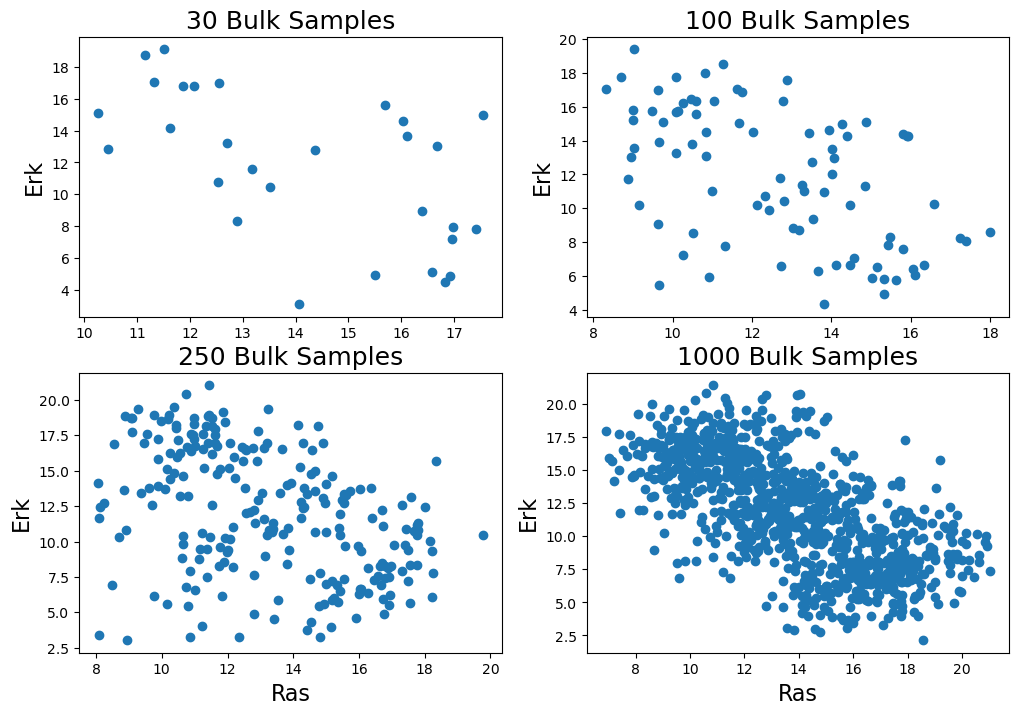

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))

ax[0,0].scatter(low_rep_bulk_protein_data["Ras"], low_rep_bulk_protein_data["Erk"])
ax[0,1].scatter(med_rep_bulk_protein_data["Ras"], med_rep_bulk_protein_data["Erk"])
ax[1,0].scatter(high_rep_bulk_protein_data["Ras"], high_rep_bulk_protein_data["Erk"])
ax[1,1].scatter(very_high_bulk_protein_data["Ras"], very_high_bulk_protein_data["Erk"])

ax[0,0].set_title("30 Bulk Samples", fontsize=18)
ax[0,1].set_title("100 Bulk Samples", fontsize=18)
ax[1,0].set_title("250 Bulk Samples", fontsize=18)
ax[1,1].set_title("1000 Bulk Samples", fontsize=18)

# ax[0,0].set_xlabel("Raf", fontsize=16)
# ax[0,1].set_xlabel("Raf", fontsize=16)
ax[1,0].set_xlabel("Ras", fontsize=16)
ax[1,1].set_xlabel("Ras", fontsize=16)

ax[0,0].set_ylabel("Erk", fontsize=16)
ax[0,1].set_ylabel("Erk", fontsize=16)
ax[1,0].set_ylabel("Erk", fontsize=16)
ax[1,1].set_ylabel("Erk", fontsize=16)

### Run inference

In [82]:
datasets = {"low" : low_rep_bulk_protein_data.iloc[:,1:], "med" : med_rep_bulk_protein_data.iloc[:,1:], 
            "high" : high_rep_bulk_protein_data.iloc[:,1:], "very_high" : very_high_bulk_protein_data.iloc[:,1:]}

intervention_results = dict()

for name, data in datasets.items():
    pyro.clear_param_store()
    lvm = LVM(data, y0_graph_bulk)
    lvm.prepare_graph()
    lvm.prepare_data()
    lvm.fit_model(num_steps=2000)
    
    lvm.intervention("Ras", "Erk", 10)
    first_int = lvm.intervention_samples
    
    lvm.intervention("Ras", "Erk", 20)
    second_int = lvm.intervention_samples
    
    intervention_results[name] = [first_int, second_int, lvm]

starting training
25554.81171824597
439.48405361175537
217.37126821279526
162.48225481808186
96.45137351751328
78.98896217346191
51.428969383239746
44.10973984003067
31.03885006904602
4.600903801620007
4.838763803243637
1.3827635943889618
3.156989574432373
-4.762497767806053
-4.151350229978561
3.4909621253609657
-9.98972375690937
-16.01582619547844
-11.712990522384644
-13.692428782582283
starting training
104565.36922768317
1459.4891136288643
781.9214378595352
578.0211361050606
427.7337401211262
316.5250046700239
293.6132006123662
195.2969908863306
181.2936089038849
191.02348796278238
127.72076562047005
109.91356714814901
107.10326674580574
103.58650244772434
98.8513380587101
43.282819747924805
77.50287768989801
64.83344087004662
62.24565610289574
98.61689496040344
starting training
197790.11125137657
3267.948085963726
1510.267598643899
877.5468508601189
507.37542490661144
206.98929934203625
61.49215589463711
-118.54560893774033
-146.47144705057144
-257.648683860898
-284.88526913523674

Text(0.5, 0, 'Erk - Log Intensity')

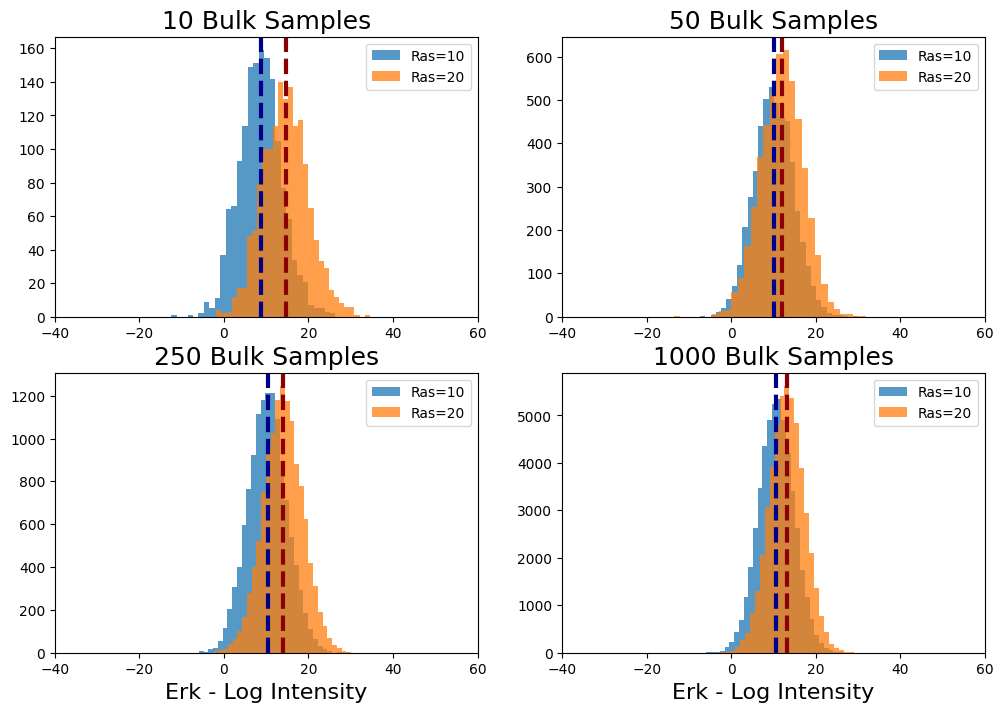

In [83]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))

ax[0,0].hist(intervention_results["low"][0], label="Ras=10", alpha=.75, bins=30)
ax[0,0].hist(intervention_results["low"][1], label="Ras=20", alpha=.75, bins=30)
ax[0,0].axvline(x=intervention_results["low"][0].mean(), color="darkblue", lw=3, linestyle="--")
ax[0,0].axvline(x=intervention_results["low"][1].mean(), color="darkred", lw=3, linestyle="--")
ax[0,0].legend()

ax[0,1].hist(intervention_results["med"][0], label="Ras=10", alpha=.75, bins=30)
ax[0,1].hist(intervention_results["med"][1], label="Ras=20", alpha=.75, bins=30)
ax[0,1].axvline(x=intervention_results["med"][0].mean(), color="darkblue", lw=3, linestyle="--")
ax[0,1].axvline(x=intervention_results["med"][1].mean(), color="darkred", lw=3, linestyle="--")
ax[0,1].legend()

ax[1,0].hist(intervention_results["high"][0], label="Ras=10", alpha=.75, bins=30)
ax[1,0].hist(intervention_results["high"][1], label="Ras=20", alpha=.75, bins=30)
ax[1,0].axvline(x=intervention_results["high"][0].mean(), color="darkblue", lw=3, linestyle="--")
ax[1,0].axvline(x=intervention_results["high"][1].mean(), color="darkred", lw=3, linestyle="--")
ax[1,0].legend()

ax[1,1].hist(intervention_results["very_high"][0], label="Ras=10", alpha=.75, bins=30)
ax[1,1].hist(intervention_results["very_high"][1], label="Ras=20", alpha=.75, bins=30)
ax[1,1].axvline(x=intervention_results["very_high"][0].mean(), color="darkblue", lw=3, linestyle="--")
ax[1,1].axvline(x=intervention_results["very_high"][1].mean(), color="darkred", lw=3, linestyle="--")
ax[1,1].legend()

ax[0,0].set_xlim(-40,60)
ax[0,1].set_xlim(-40,60)
ax[1,0].set_xlim(-40,60)
ax[1,1].set_xlim(-40,60)

ax[0,0].set_title("10 Bulk Samples", fontsize=18)
ax[0,1].set_title("50 Bulk Samples", fontsize=18)
ax[1,0].set_title("250 Bulk Samples", fontsize=18)
ax[1,1].set_title("1000 Bulk Samples", fontsize=18)

ax[1,0].set_xlabel("Erk - Log Intensity", size=16)
ax[1,1].set_xlabel("Erk - Log Intensity", size=16)

## High dynamic range

In [42]:
## Coefficients for relations
cell_coef_high_range = {'EGF': {'intercept': 18., "error": 8},
              'IGF': {'intercept': 17., "error": 8},
              'SOS': {'intercept': -4, "error": 1, 
                      'EGF': 0.6, 'IGF': 0.6,},
              'Ras': {'intercept': 5, "error": 1, 'SOS': .5, "cell_type" : [3, 0, -3]},
              'PI3K': {'intercept': 1.6, "error": 1, 
                       'EGF': .5, 'IGF': 0.5, 'Ras': .5,},
              'Akt': {'intercept': 2., "error": 1, 'PI3K': 0.75, },
              'Raf': {'intercept': 2, "error": 1,
                      'Ras': 0.8, 'Akt': -.4, "cell_type" : [-2, 0, 2]},
              'Mek': {'intercept': 3., "error": 1, 'Raf': 0.75, "cell_type" : [-2, 0, 2]},
              'Erk': {'intercept': 4., "error": 1, 'Mek': 1.2, "cell_type" : [-2, 0, 2]}
             }

In [43]:
low_rep_range_data = simulate_data(cell_type_graph, coefficients=cell_coef_high_range, include_missing=True, 
                                  cell_type=True, n_cells=3, n=30, seed=0)
med_rep_range_data = simulate_data(cell_type_graph, coefficients=cell_coef_high_range, include_missing=True, 
                                  cell_type=True, n_cells=3, n=100, seed=0)
high_rep_range_data = simulate_data(cell_type_graph, coefficients=cell_coef_high_range, include_missing=True, 
                                   cell_type=True, n_cells=3, n=250, seed=0)
# very_high_rep_bulk_data = simulate_data(cell_type_graph, coefficients=cell_coef, include_missing=True, 
#                                         cell_type=True, n_cells=3, n=1000, seed=1)

simulating data...
adding feature level data...
masking data...
simulating data...
adding feature level data...
masking data...
simulating data...
adding feature level data...
masking data...


In [48]:
low_rep_range_data["Feature_data"].to_csv("../data/IGF_pathway/low_rep_range_feature_data.csv", index=False)
med_rep_range_data["Feature_data"].to_csv("../data/IGF_pathway/med_rep_range_feature_data.csv", index=False)
high_rep_range_data["Feature_data"].to_csv("../data/IGF_pathway/high_rep_range_feature_data.csv", index=False)

In [53]:
low_rep_range_protein_data = pd.read_csv("../data/IGF_pathway/low_rep_range_protein_data.csv")
med_rep_range_protein_data = pd.read_csv("../data/IGF_pathway/med_rep_range_protein_data.csv")
high_rep_range_protein_data = pd.read_csv("../data/IGF_pathway/high_rep_range_protein_data.csv")

### Analysis

Text(0, 0.5, 'Mek')

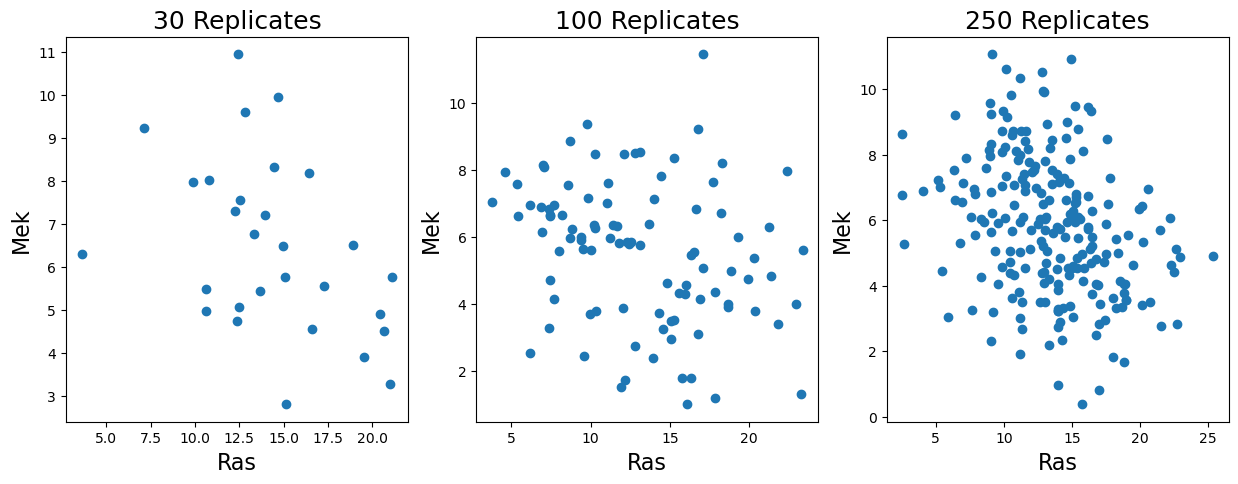

In [60]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

ax[0].scatter(low_rep_range_protein_data["Ras"], low_rep_range_protein_data["Mek"])
ax[1].scatter(med_rep_range_protein_data["Ras"], med_rep_range_protein_data["Mek"])
ax[2].scatter(high_rep_range_protein_data["Ras"], high_rep_range_protein_data["Mek"])

ax[0].set_title("30 Replicates", fontsize=18)
ax[1].set_title("100 Replicates", fontsize=18)
ax[2].set_title("250 Replicates", fontsize=18)

# ax[0,0].s|et_xlabel("Raf", fontsize=16)
# ax[0,1].set_xlabel("Raf", fontsize=16)
ax[0].set_xlabel("Ras", fontsize=16)
ax[1].set_xlabel("Ras", fontsize=16)
ax[2].set_xlabel("Ras", fontsize=16)

                  
ax[0].set_ylabel("Mek", fontsize=16)
ax[1].set_ylabel("Mek", fontsize=16)
ax[2].set_ylabel("Mek", fontsize=16)

### Run inference

In [61]:
datasets = {"low" : low_rep_range_protein_data, "med" : med_rep_range_protein_data, 
            "high" : high_rep_range_protein_data}

intervention_results = dict()

for name, data in datasets.items():
    scm = SCM(data, y0_graph_bulk)
    scm.prepare_scm_input()
    scm.fit_scm(num_samples=1000, warmup_steps=3000, num_chains=4)
    
    scm.intervention("Ras", "Erk", 10)
    first_int = scm.intervention_samples
    
    scm.intervention("Ras", "Erk", 20)
    second_int = scm.intervention_samples
    
    intervention_results[name] = [first_int, second_int, scm]

Finding root nodes...
Adding latent confounders to graph...
Determining missing obs...
Running MCMC...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Finding root nodes...
Adding latent confounders to graph...
Determining missing obs...
Running MCMC...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Finding root nodes...
Adding latent confounders to graph...
Determining missing obs...
Running MCMC...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Log Intensity')

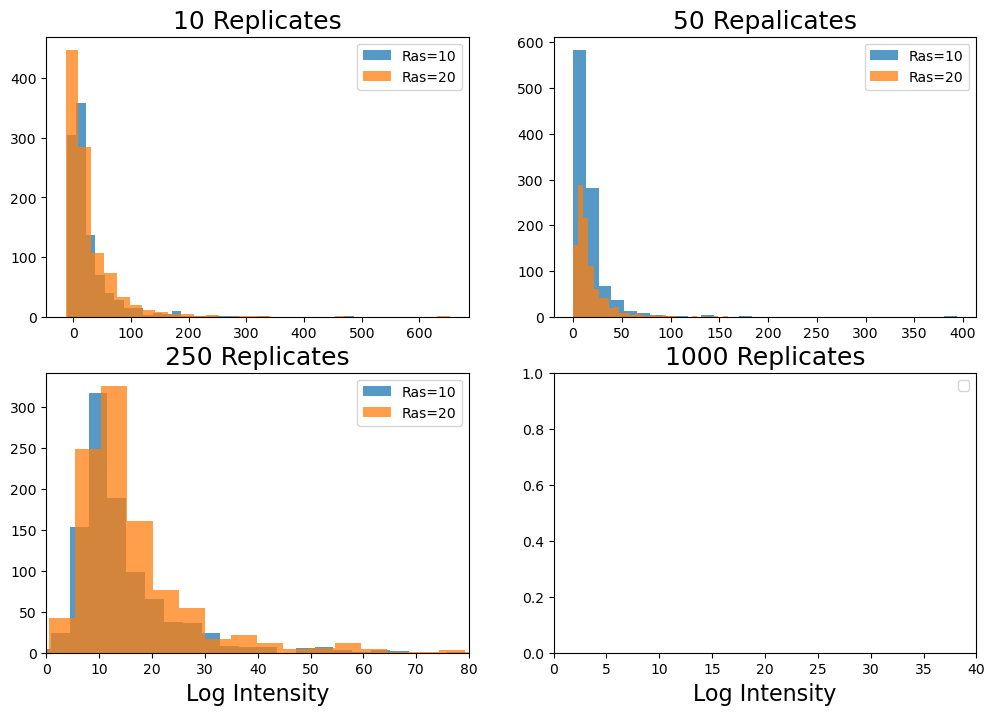

In [62]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))

ax[0,0].hist(intervention_results["low"][0], label="Ras=10", alpha=.75, bins=30)
ax[0,0].hist(intervention_results["low"][1], label="Ras=20", alpha=.75, bins=30)
# ax[0,0].axvline(x=np.mean(gt_int_data[0]), color="Blue", lw=2, linestyle="--", label="Ground Truth Ras=10")
# ax[0,0].axvline(x=np.mean(gt_int_data[1]), color="Red", lw=2, linestyle="--", label="Ground Truth Ras=20")
ax[0,0].legend()

ax[0,1].hist(intervention_results["med"][0], label="Ras=10", alpha=.75, bins=30)
ax[0,1].hist(intervention_results["med"][1], label="Ras=20", alpha=.75, bins=30)
# ax[0,1].axvline(x=np.mean(gt_int_data[0]), color="Blue", lw=2, linestyle="--", label="Ground Truth Ras=10")
# ax[0,1].axvline(x=np.mean(gt_int_data[1]), color="Red", lw=2, linestyle="--", label="Ground Truth Ras=20")
ax[0,1].legend()

ax[1,0].hist(intervention_results["high"][0], label="Ras=10", alpha=.75, bins=30)
ax[1,0].hist(intervention_results["high"][1], label="Ras=20", alpha=.75, bins=30)
# ax[1,0].axvline(x=np.mean(gt_int_data[0]), color="Blue", lw=2, linestyle="--", label="Ground Truth Ras=10")
# ax[1,0].axvline(x=np.mean(gt_int_data[1]), color="Red", lw=2, linestyle="--", label="Ground Truth Ras=20")
ax[1,0].legend()

# ax[1,1].hist(intervention_results["very_high"][0], label="Ras=10", alpha=.75, bins=30)
# ax[1,1].hist(intervention_results["very_high"][1], label="Ras=20", alpha=.75, bins=30)
# ax[1,1].axvline(x=np.mean(gt_int_data[0]), color="Blue", lw=2, linestyle="--", label="Ground Truth Ras=10")
# ax[1,1].axvline(x=np.mean(gt_int_data[1]), color="Red", lw=2, linestyle="--", label="Ground Truth Ras=20")
# ax[1,1].legend(fontsize=20)

ax[1,0].set_xlim(0,80)
ax[1,1].set_xlim(0,40)

plt.legend()
ax[0,0].set_title("10 Replicates", fontsize=18)
ax[0,1].set_title("50 Repalicates", fontsize=18)
ax[1,0].set_title("250 Replicates", fontsize=18)
ax[1,1].set_title("1000 Replicates", fontsize=18)

ax[1,0].set_xlabel("Log Intensity", fontsize=16)
ax[1,1].set_xlabel("Log Intensity", fontsize=16)

## Bad node measurements

Here we simulate a high error for Mek, which is along the causal path from Ras to Erk

In [65]:
bad_node_data = simulate_data(cell_type_graph, coefficients=cell_coef, include_missing=True, 
                              add_error=True, error_node="Mek", n=250, seed=1)

simulating data...
adding feature level data...


/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:201: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_level_data = pd.concat([feature_level_data, pd.DataFrame({"Protein": [node],
/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:201: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_level_data = pd.con

masking data...


/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:240: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  feature_level_data.loc[i, "MAR"] = False
/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:246: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  feature_level_data.loc[i, "MNAR"] = False


In [66]:
bad_node_data["Feature_data"].to_csv("../data/IGF_pathway/bad_node_feature_data.csv", index=False)

In [70]:
bad_node_protein_data = pd.read_csv("../data/IGF_pathway/bad_node_protein_data.csv")

### Analysis

In [71]:
single_cell_lm = linear_model.LinearRegression()

ras_erk_lm = linear_model.LinearRegression()
x = bad_node_protein_data.dropna()[["Ras"]]
y = bad_node_protein_data.dropna()[["Erk"]]
ras_erk_lm.fit(x, y)

LinearRegression()

(array([ 4.,  6.,  8., 10., 12., 14., 16., 18.]),
 [Text(0, 4.0, '4'),
  Text(0, 6.0, '6'),
  Text(0, 8.0, '8'),
  Text(0, 10.0, '10'),
  Text(0, 12.0, '12'),
  Text(0, 14.0, '14'),
  Text(0, 16.0, '16'),
  Text(0, 18.0, '18')])

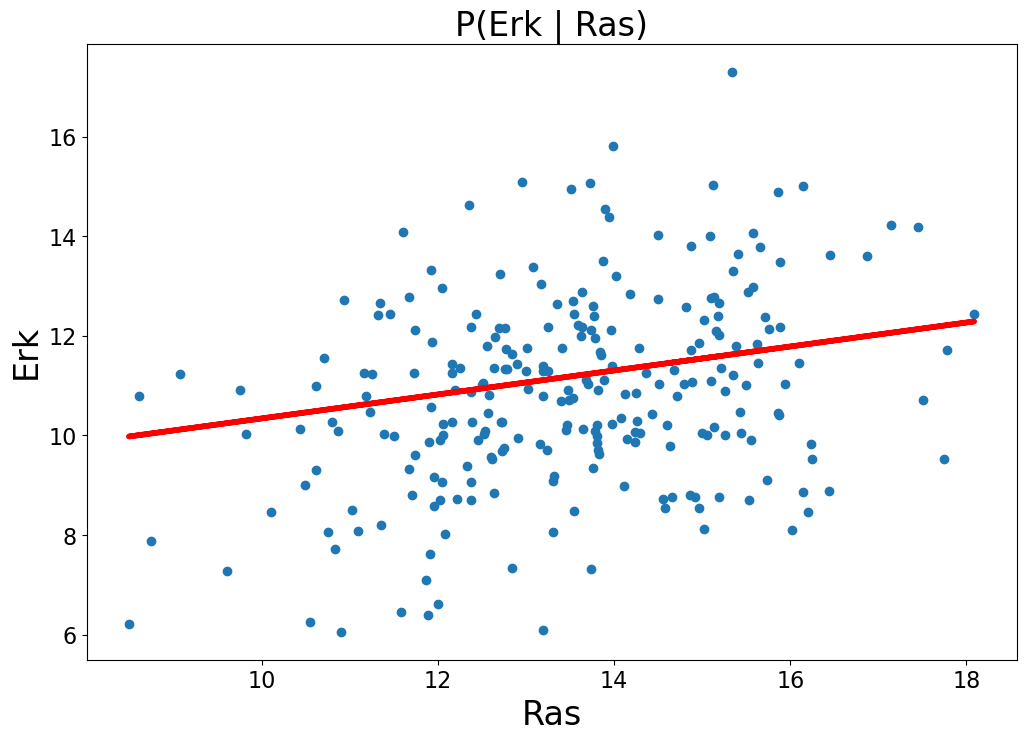

In [72]:
fig, ax = plt.subplots(figsize=(12,8))

x = bad_node_protein_data["Ras"]
y = bad_node_protein_data["Erk"]

ax.scatter(x, y)
ax.plot(bad_node_protein_data["Ras"], 
           ras_erk_lm.coef_[0]*bad_node_protein_data["Ras"] + ras_erk_lm.intercept_[0], 
           color="red", lw=4)

ax.set_title("P(Erk | Ras)", size=24)
ax.set_xlabel("Ras", size=24)
ax.set_ylabel("Erk", size=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

In [73]:
single_cell_lm = linear_model.LinearRegression()

ras_raf_lm = linear_model.LinearRegression()
x = bad_node_protein_data.dropna()[["Ras"]]
y = bad_node_protein_data.dropna()[["Raf"]]
ras_raf_lm.fit(x, y)

raf_mek_lm = linear_model.LinearRegression()
x = bad_node_protein_data.dropna()[["Raf"]]
y = bad_node_protein_data.dropna()[["Mek"]]
raf_mek_lm.fit(x, y)

mek_erk_lm = linear_model.LinearRegression()
x = bad_node_protein_data.dropna()[["Mek"]]
y = bad_node_protein_data.dropna()[["Erk"]]
mek_erk_lm.fit(x, y)

LinearRegression()

Text(0, 0.5, 'Erk')

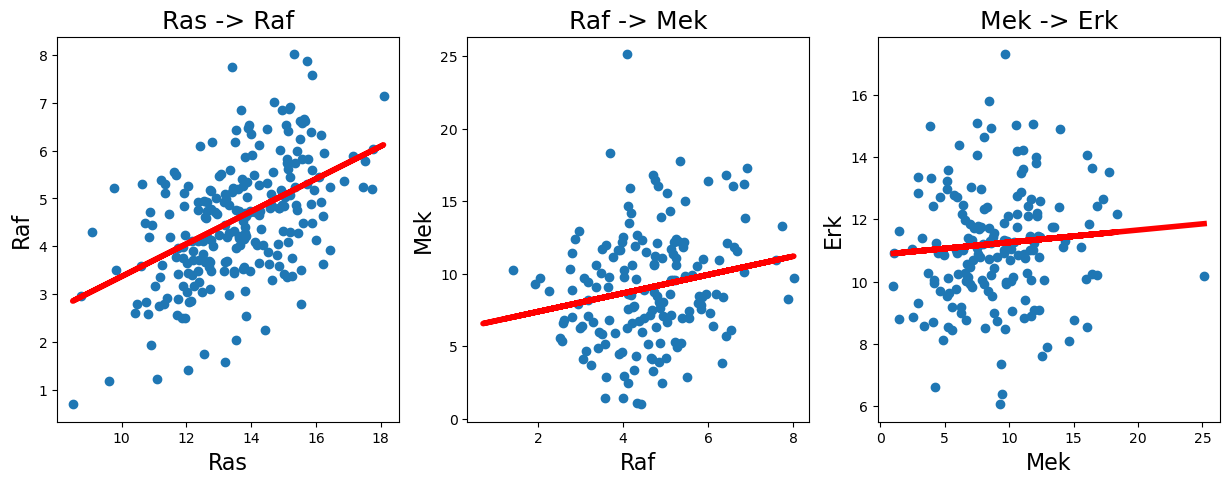

In [74]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

ax[0].scatter(bad_node_protein_data["Ras"], bad_node_protein_data["Raf"])
ax[0].plot(bad_node_protein_data["Ras"], 
           ras_raf_lm.coef_[0]*bad_node_protein_data["Ras"] + ras_raf_lm.intercept_[0], 
           color="red", lw=4)

ax[1].scatter(bad_node_protein_data["Raf"], bad_node_protein_data["Mek"])
ax[1].plot(bad_node_protein_data["Raf"], 
           raf_mek_lm.coef_[0]*bad_node_protein_data["Raf"] + raf_mek_lm.intercept_[0], 
           color="red", lw=4)

ax[2].scatter(bad_node_protein_data["Mek"], bad_node_protein_data["Erk"])
ax[2].plot(bad_node_protein_data["Mek"], 
           mek_erk_lm.coef_[0]*bad_node_protein_data["Mek"] + mek_erk_lm.intercept_[0], 
           color="red", lw=4)

ax[0].set_title("Ras -> Raf", fontsize=18)
ax[1].set_title("Raf -> Mek", fontsize=18)
ax[2].set_title("Mek -> Erk", fontsize=18)

ax[0].set_xlabel("Ras", fontsize=16)                  
ax[0].set_ylabel("Raf", fontsize=16)

ax[1].set_xlabel("Raf", fontsize=16)                  
ax[1].set_ylabel("Mek", fontsize=16)

ax[2].set_xlabel("Mek", fontsize=16)                  
ax[2].set_ylabel("Erk", fontsize=16)

### Run inference

In [75]:
scm = SCM(bad_node_protein_data, y0_graph_bulk)
scm.prepare_scm_input()
scm.fit_scm(num_samples=1000, warmup_steps=4000, num_chains=4)

scm.intervention("Ras", "Erk", 10)
first_int = scm.intervention_samples

scm.intervention("Ras", "Erk", 20)
second_int = scm.intervention_samples

Finding root nodes...
Adding latent confounders to graph...
Determining missing obs...
Running MCMC...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [76]:
np.mean(np.array(second_int)) - np.mean(np.array(first_int))

0.32441425

(0.0, 25.0)

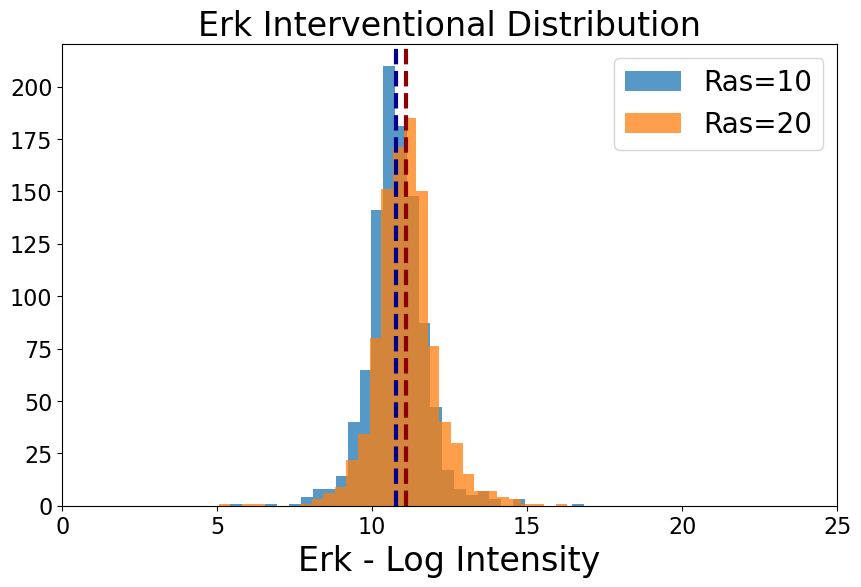

In [79]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(np.array(first_int), bins=30, alpha=.75, label="Ras=10")
ax.hist(np.array(second_int), bins=30, alpha=.75, label="Ras=20")
ax.axvline(x=np.mean(first_int), color="darkblue", lw=3, linestyle="--")
ax.axvline(x=np.mean(second_int), color="darkred", lw=3, linestyle="--")

ax.legend(fontsize=20)
ax.set_title("Erk Interventional Distribution", size=24)
ax.set_xlabel("Erk - Log Intensity", size=24)
# ax.set_ylabel("Erk", size=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


ax.set_xlim(0,25)

### Remove Mek

In [80]:
y0_no_mek = copy.copy(y0_graph_bulk)
y0_no_mek.directed.remove_edge(Variable("Raf"), Variable("Mek"))
y0_no_mek.directed.remove_edge(Variable("Mek"), Variable("Erk"))
y0_no_mek.directed.add_edge(Variable("Raf"), Variable("Erk"))

In [81]:
scm = SCM(bad_node_protein_data, y0_no_mek)
scm.prepare_scm_input()
scm.fit_scm(num_samples=1000, warmup_steps=4000, num_chains=4)

scm.intervention("Ras", "Erk", 10)
first_int = scm.intervention_samples

scm.intervention("Ras", "Erk", 20)
second_int = scm.intervention_samples

Finding root nodes...
Adding latent confounders to graph...
Determining missing obs...
Running MCMC...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [82]:
np.mean(np.array(second_int)) - np.mean(np.array(first_int))

4.8653183

(0.0, 25.0)

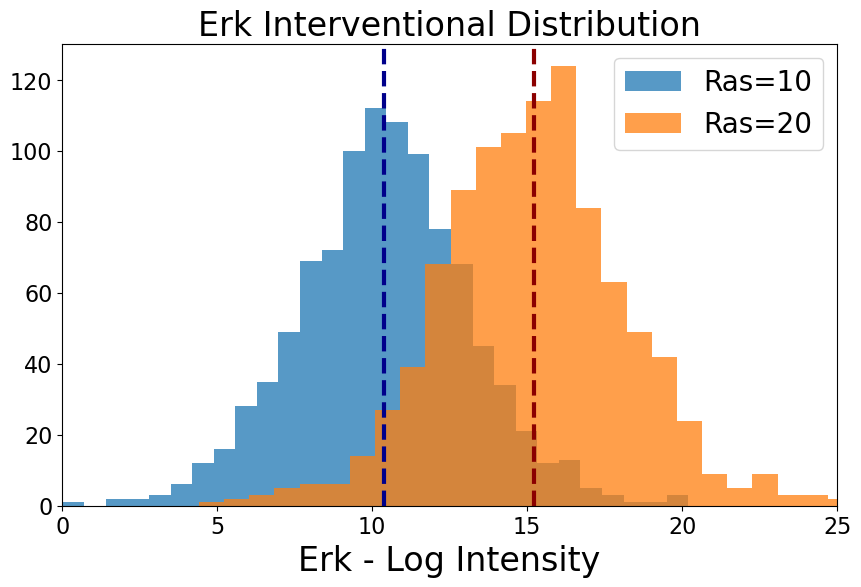

In [85]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(np.array(first_int), bins=30, alpha=.75, label="Ras=10")
ax.hist(np.array(second_int), bins=30, alpha=.75, label="Ras=20")
ax.axvline(x=np.mean(first_int), color="darkblue", lw=3, linestyle="--")
ax.axvline(x=np.mean(second_int), color="darkred", lw=3, linestyle="--")

ax.legend(fontsize=20)
ax.set_title("Erk Interventional Distribution", size=24)
ax.set_xlabel("Erk - Log Intensity", size=24)
# ax.set_ylabel("Erk", size=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


ax.set_xlim(0,25)

## Missingness

### Simulate Data

In [11]:
high_missing_data = simulate_data(bulk_graph, coefficients=cell_coef, include_missing=True, 
                                  mar_missing_param=.1, mnar_missing_param=[-3, .15], 
                                  n=250, seed=0)

simulating data...
adding feature level data...
masking data...


In [13]:
high_missing_data["Feature_data"].to_csv("../data/IGF_pathway/high_missing_feature_data.csv", index=False)

In [84]:
high_missing_protein_data = pd.read_csv("../../data/IGF_pathway/high_missing_protein_data.csv")

### Initial Analysis

Text(0.5, 1.0, 'MNAR Curve - High Probability')

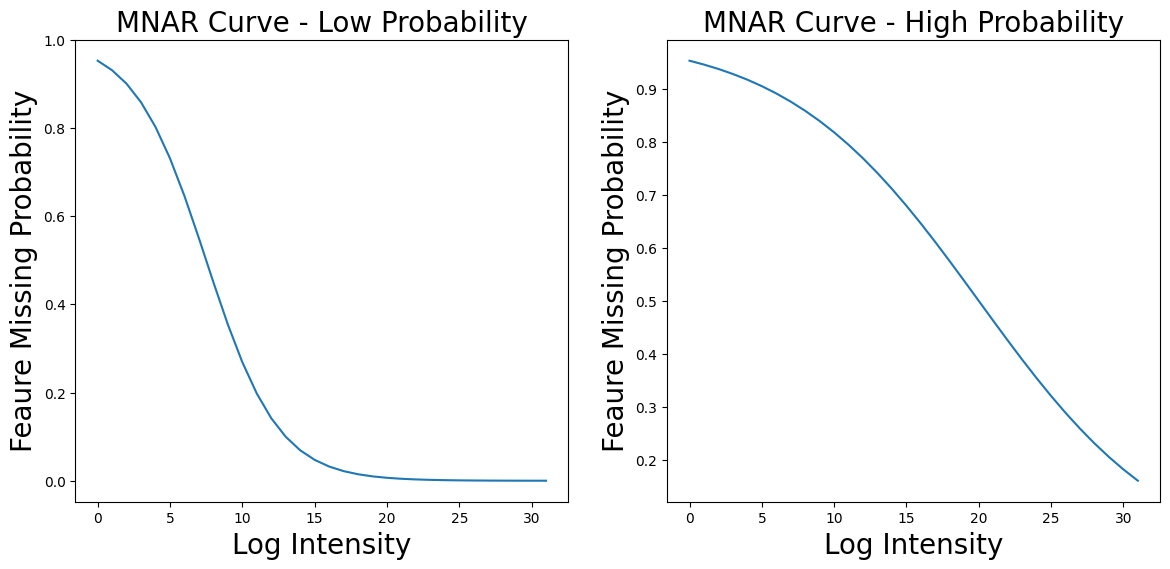

In [85]:
fig, ax = plt.subplots(1,2,figsize=(14,6))


mnar_thresh = [1 / (1 + np.exp(-3 + (.4 * i))) for i in range(0, 32)]
ax[0].plot(mnar_thresh)

mnar_thresh = [1 / (1 + np.exp(-3 + (.15 * i))) for i in range(0, 32)]
ax[1].plot(mnar_thresh)

ax[0].set_xlabel("Log Intensity", size=20)
ax[1].set_xlabel("Log Intensity", size=20)

ax[0].set_ylabel("Feaure Missing Probability", size=20)
ax[1].set_ylabel("Feaure Missing Probability", size=20)

ax[0].set_title("MNAR Curve - Low Probability", size=20)
ax[1].set_title("MNAR Curve - High Probability", size=20)

Text(0, 0.5, 'Percent Missing Replicates')

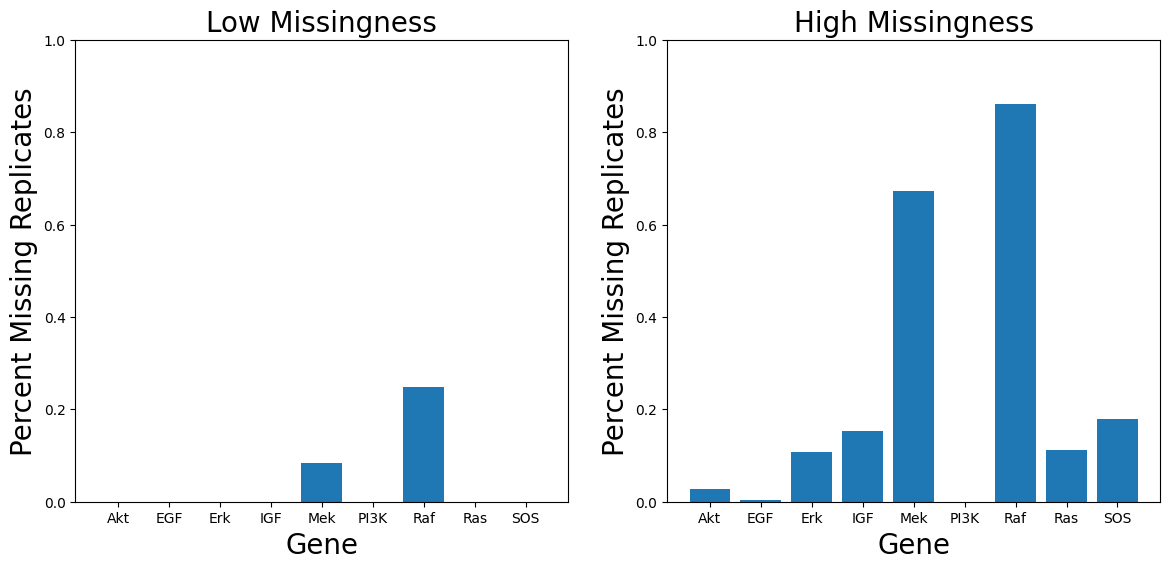

In [86]:
fig, ax = plt.subplots(1,2, figsize=(14,6))

ax[0].bar(x = high_rep_protein_data.iloc[: ,1:].isnull().sum(axis = 0).index,
          height=high_rep_protein_data.iloc[: ,1:].isnull().sum(axis = 0) / len(high_rep_protein_data))

ax[1].bar(x = high_missing_protein_data.iloc[: ,1:].isnull().sum(axis = 0).index, 
       height=high_missing_protein_data.iloc[: ,1:].isnull().sum(axis = 0) / len(high_missing_protein_data))

ax[0].set_ylim(0,1)
ax[1].set_ylim(0,1)

ax[0].set_title("Low Missingness", size=20)
ax[1].set_title("High Missingness", size=20)

ax[0].set_xlabel("Gene", size=20)
ax[1].set_xlabel("Gene", size=20)

ax[0].set_ylabel("Percent Missing Replicates", size=20)
ax[1].set_ylabel("Percent Missing Replicates", size=20)

In [87]:
low_missing_lm = linear_model.LinearRegression()
x = high_rep_protein_data.dropna()[["Raf"]]
y = high_rep_protein_data.dropna()[["Mek"]]
low_missing_lm.fit(x, y)

high_missing_lm = linear_model.LinearRegression()
x = high_missing_protein_data.dropna()[["Raf"]]
y = high_missing_protein_data.dropna()[["Mek"]]
high_missing_lm.fit(x, y)

LinearRegression()

Text(0, 0.5, 'Mek')

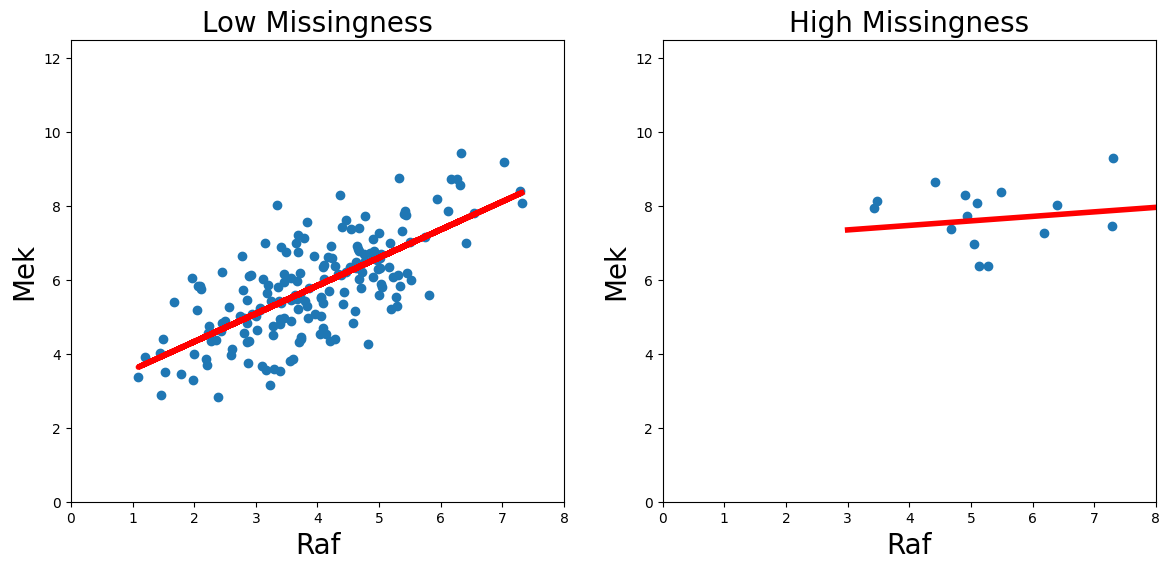

In [88]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

ax[0].scatter(high_rep_protein_data["Raf"], high_rep_protein_data["Mek"])
ax[0].plot(high_rep_protein_data["Raf"], 
           low_missing_lm.coef_[0]*high_rep_protein_data["Raf"] + low_missing_lm.intercept_[0], 
           color="red", lw=4)

ax[1].scatter(high_missing_protein_data["Raf"], high_missing_protein_data["Mek"])
ax[1].plot(np.arange(3,8.5), 
           high_missing_lm.coef_[0]*np.arange(3,8.5) + high_missing_lm.intercept_[0], 
           color="red", lw=4)

ax[0].set_xlim(0,8)
ax[1].set_xlim(0,8)
ax[0].set_ylim(0,12.5)
ax[1].set_ylim(0,12.5)

ax[0].set_title("Low Missingness", size=20)
ax[1].set_title("High Missingness", size=20)

ax[0].set_xlabel("Raf", size=20)
ax[1].set_xlabel("Raf", size=20)

ax[0].set_ylabel("Mek", size=20)
ax[1].set_ylabel("Mek", size=20)

### Run inference

In [97]:
pyro.clear_param_store()
lvm = LVM(high_missing_protein_data.iloc[:,1:], y0_graph_bulk)
lvm.prepare_graph()
lvm.prepare_data()
lvm.fit_model(num_steps=4000)

starting training
184243.92719088122


4233.505686044693
2332.8048359155655
1468.459408402443
975.8176956176758
646.8339190483093
301.93671828508377
56.585867166519165
-216.82602906227112
-383.77267464995384
-523.3544753938913
-709.5652386918664
-687.9973057359457
-789.1434153020382
-867.5054114237428
-912.0158677324653
-1003.506409034133
-1040.7018980309367
-1070.297362998128
-1108.6544145196676
-1093.7601431198418
-1142.891032334417
-1172.8556073084474
-1201.053297355771
-1170.371837504208
-1202.880731630139
-1241.695541604422
-1227.7066356241703
-1269.1235647182912
-1256.0531806871295
-1341.455655425787
-1252.8356972644106
-1302.2419225908816
-1307.8280639071018
-1307.9871337283403
-1312.601622757502
-1309.0857254201546
-1383.5388398580253
-1336.1975916139781
-1295.0229130536318


In [98]:
intervention_results["high"][1].mean() - intervention_results["high"][0].mean()

tensor(3.6107)

In [99]:
lvm.intervention("Ras", "Erk", 10)
first_int = lvm.intervention_samples

lvm.intervention("Ras", "Erk", 20)
second_int = lvm.intervention_samples

high_missing_intervention_results = [first_int, second_int, lvm]

np.mean(np.array(high_missing_intervention_results[1])) - np.mean(np.array(high_missing_intervention_results[0]))

0.5597248

Text(0.5, 0, 'Erk - Log Intensity')

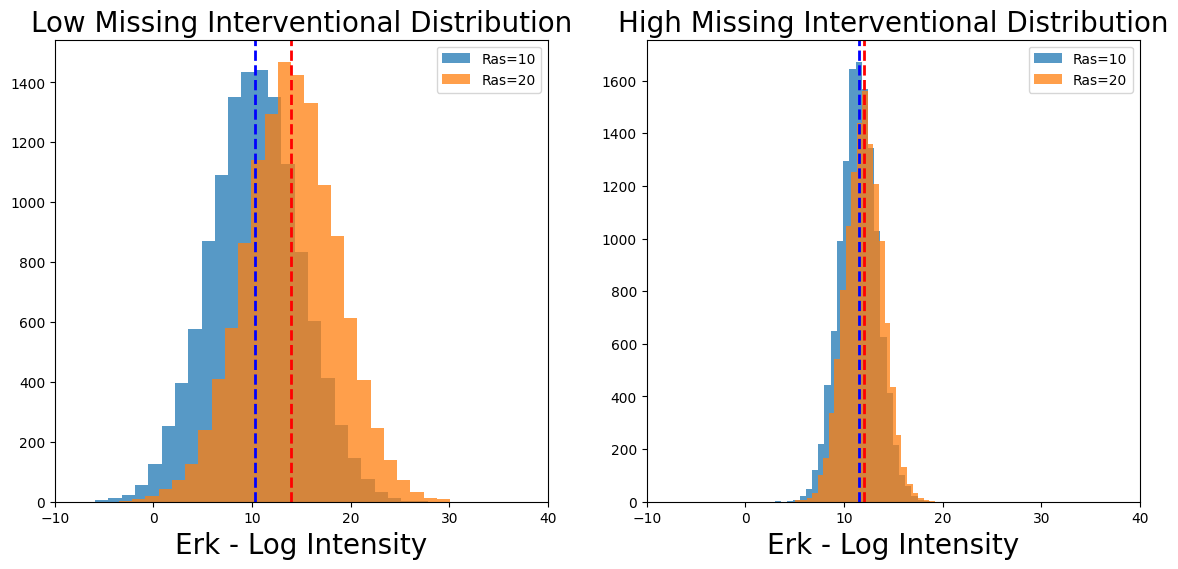

In [101]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

ax[0].hist(intervention_results["high"][0], label="Ras=10", alpha=.75, bins=25)
ax[0].hist(intervention_results["high"][1], label="Ras=20", alpha=.75, bins=25)
ax[0].axvline(x=intervention_results["high"][0].mean(), color="Blue", lw=2, linestyle="--")
ax[0].axvline(x=intervention_results["high"][1].mean(), color="Red", lw=2, linestyle="--")
ax[0].legend()

ax[1].hist(high_missing_intervention_results[0], label="Ras=10", alpha=.75, bins=25)
ax[1].hist(high_missing_intervention_results[1], label="Ras=20", alpha=.75, bins=25)
ax[1].axvline(x=high_missing_intervention_results[0].mean(), color="Blue", lw=2, linestyle="--")
ax[1].axvline(x=high_missing_intervention_results[1].mean(), color="Red", lw=2, linestyle="--")
ax[1].legend()

ax[0].set_xlim(-10,40)
ax[1].set_xlim(-10,40)

plt.legend()

ax[0].set_title("Low Missing Interventional Distribution", size=20)
ax[0].set_xlabel("Erk - Log Intensity", size=20)

ax[1].set_title("High Missing Interventional Distribution", size=20)
ax[1].set_xlabel("Erk - Log Intensity", size=20)

# # ax.set_ylabel("Erk", size=24)
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)

### Checkout simulated data - Comparison

Add in imputed values

In [104]:
lvm.imputed_data

,protein,intensity,imp_mean,imp_scale
0,Akt,23.969978,NaN,NaN
1,Akt,20.685257,NaN,NaN
2,Akt,18.480347,NaN,NaN
3,Akt,19.260349,NaN,NaN
4,Akt,18.822550,NaN,NaN
...,...,...,...,...
2245,SOS,14.168043,NaN,NaN
2246,SOS,11.151333,NaN,NaN
2247,SOS,14.571370,NaN,NaN
2248,SOS,NaN,15.232384,1.839352


In [51]:
mek_imp = lvm.summary_stats["imp_Mek"]["mean"]
raf_imp = scm.summary_stats["imp_Raf"]["mean"]
mek_std = scm.summary_stats["imp_Mek"]["std"]
raf_std = scm.summary_stats["imp_Raf"]["std"]

## Add in missing data
high_missing_protein_data.loc[:, "imp_Mek"] = high_missing_protein_data.loc[:, "Mek"].isna()
high_missing_protein_data.loc[:, "imp_Raf"] = high_missing_protein_data.loc[:, "Raf"].isna()
high_missing_protein_data.loc[:, "full_Mek"] = high_missing_protein_data.loc[:, "Mek"]
high_missing_protein_data.loc[:, "full_Raf"] = high_missing_protein_data.loc[:, "Raf"]

high_missing_protein_data.loc[:, "Mek_std"] = np.nan
high_missing_protein_data.loc[:, "Raf_std"] = np.nan
high_missing_protein_data.loc[high_missing_protein_data["imp_Mek"], "Mek_std"] = mek_std
high_missing_protein_data.loc[high_missing_protein_data["imp_Raf"], "Raf_std"] = raf_std

high_missing_protein_data.loc[high_missing_protein_data["imp_Mek"], "full_Mek"] = mek_imp
high_missing_protein_data.loc[high_missing_protein_data["imp_Raf"], "full_Raf"] = raf_imp

mek_imp_high = intervention_results["high"][2].summary_stats["imp_Mek"]["mean"]
raf_imp_high = intervention_results["high"][2].summary_stats["imp_Raf"]["mean"]
mek_std_high = intervention_results["high"][2].summary_stats["imp_Mek"]["std"]
raf_std_high = intervention_results["high"][2].summary_stats["imp_Raf"]["std"]

## Add in missing data
high_rep_protein_data.loc[:, "imp_Mek"] = high_rep_protein_data.loc[:, "Mek"].isna()
high_rep_protein_data.loc[:, "imp_Raf"] = high_rep_protein_data.loc[:, "Raf"].isna()
high_rep_protein_data.loc[:, "full_Mek"] = high_rep_protein_data.loc[:, "Mek"]
high_rep_protein_data.loc[:, "full_Raf"] = high_rep_protein_data.loc[:, "Raf"]

high_rep_protein_data.loc[:, "Mek_std"] = np.nan
high_rep_protein_data.loc[:, "Raf_std"] = np.nan
high_rep_protein_data.loc[high_rep_protein_data["imp_Mek"], "Mek_std"] = mek_std_high
high_rep_protein_data.loc[high_rep_protein_data["imp_Raf"], "Raf_std"] = raf_std_high

high_rep_protein_data.loc[high_rep_protein_data["imp_Mek"], "full_Mek"] = mek_imp_high
high_rep_protein_data.loc[high_rep_protein_data["imp_Raf"], "full_Raf"] = raf_imp_high

Calculate regression lines

In [48]:
low_missing_lm = linear_model.LinearRegression()
x = high_rep_protein_data.dropna()[["Raf"]]
y = high_rep_protein_data.dropna()[["Mek"]]
low_missing_lm.fit(x, y)

low_missing_imp_lm = linear_model.LinearRegression()
x = high_rep_protein_data[["full_Raf"]]
y = high_rep_protein_data[["full_Mek"]]
low_missing_imp_lm.fit(x, y)

high_missing_lm = linear_model.LinearRegression()
x = high_missing_protein_data.dropna()[["Raf"]]
y = high_missing_protein_data.dropna()[["Mek"]]
high_missing_lm.fit(x, y)

high_missing_imp_lm = linear_model.LinearRegression()
x = high_missing_protein_data[["full_Raf"]]
y = high_missing_protein_data[["full_Mek"]]
high_missing_imp_lm.fit(x, y)

LinearRegression()

Plot

Text(0, 0.5, 'Mek')

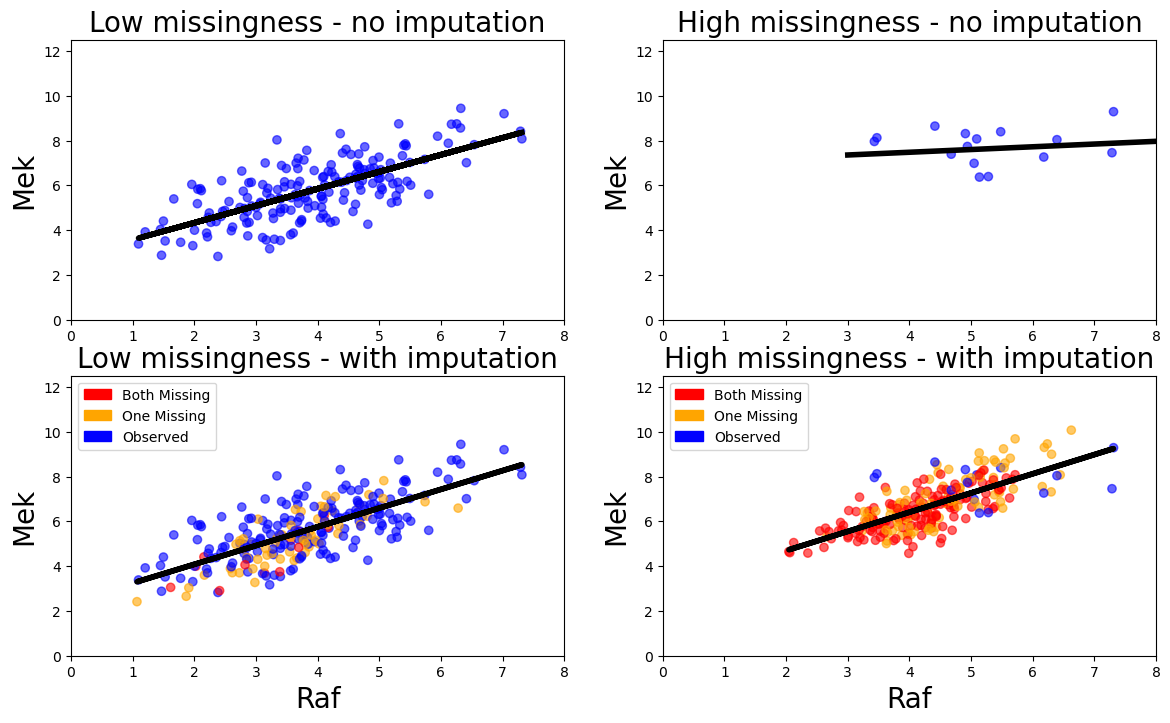

In [49]:
## Plot
fig, ax = plt.subplots(2, 2, figsize=(14,8))

colors1 = np.where((high_rep_protein_data["imp_Mek"] == True) & \
                   (high_rep_protein_data["imp_Raf"] == True), "Red", 
                  np.where((high_rep_protein_data["imp_Raf"] == True) | \
                           (high_rep_protein_data["imp_Mek"] == True), "Orange", "Blue"))

colors2 = np.where((high_missing_protein_data["imp_Mek"] == True) & \
                   (high_missing_protein_data["imp_Raf"] == True), "Red", 
                  np.where((high_missing_protein_data["imp_Raf"] == True) | \
                           (high_missing_protein_data["imp_Mek"] == True), "Orange", "Blue"))

ax[0,0].scatter(high_rep_protein_data["Raf"], high_rep_protein_data["Mek"], c=colors1, alpha=.6)
ax[0,0].plot(high_rep_protein_data["Raf"], 
           low_missing_lm.coef_[0]*high_rep_protein_data["Raf"] + low_missing_lm.intercept_[0], 
           color="black", lw=4)

ax[1,0].scatter(high_rep_protein_data["full_Raf"], high_rep_protein_data["full_Mek"], 
              c=colors1, alpha=.6)
ax[1,0].plot(high_rep_protein_data["full_Raf"], 
           low_missing_imp_lm.coef_[0]*high_rep_protein_data["full_Raf"] + low_missing_imp_lm.intercept_[0], 
           color="black", lw=4)

ax[0,1].scatter(high_missing_protein_data["Raf"], high_missing_protein_data["Mek"], 
              c=colors2, alpha=.6)
ax[0,1].plot(np.arange(3,9), 
           high_missing_lm.coef_[0]*np.arange(3,9) + high_missing_lm.intercept_[0], 
           color="black", lw=4)

ax[1,1].scatter(high_missing_protein_data["full_Raf"], high_missing_protein_data["full_Mek"], 
              c=colors2, alpha=.6)
ax[1,1].plot(high_missing_protein_data["full_Raf"], 
           high_missing_imp_lm.coef_[0]*high_missing_protein_data["full_Raf"] + high_missing_imp_lm.intercept_[0], 
           color="black", lw=4)

red_patch = mpatches.Patch(color='red', label='Both Missing')
orange_patch = mpatches.Patch(color='orange', label='One Missing')
blue_patch = mpatches.Patch(color='blue', label='Observed')

ax[1,1].legend(handles=[red_patch, orange_patch, blue_patch])
ax[1,0].legend(handles=[red_patch, orange_patch, blue_patch])

ax[0,0].set_xlim(0,8)
ax[1,1].set_xlim(0,8)
ax[0,1].set_xlim(0,8)
ax[1,0].set_xlim(0,8)
ax[0,0].set_ylim(0,12.5)
ax[1,1].set_ylim(0,12.5)
ax[0,1].set_ylim(0,12.5)
ax[1,0].set_ylim(0,12.5)

ax[0,0].set_title("Low missingness - no imputation", size=20)
ax[1,1].set_title("High missingness - with imputation", size=20)
ax[1,0].set_title("Low missingness - with imputation", size=20)
ax[0,1].set_title("High missingness - no imputation", size=20)

# ax[0,0].set_xlabel("Raf")
# ax[0,1].set_xlabel("Raf")
ax[1,1].set_xlabel("Raf", size=20)
ax[1,0].set_xlabel("Raf", size=20)

ax[0,0].set_ylabel("Mek", size=20)
ax[0,1].set_ylabel("Mek", size=20)
ax[1,1].set_ylabel("Mek", size=20)
ax[1,0].set_ylabel("Mek", size=20)

### Checkout simulated data - only high missing

In [12]:
mek_imp = scm.summary_stats["imp_Mek"]["mean"]
raf_imp = scm.summary_stats["imp_Raf"]["mean"]
mek_std = scm.summary_stats["imp_Mek"]["std"]
raf_std = scm.summary_stats["imp_Raf"]["std"]

## Add in missing data
high_missing_protein_data.loc[:, "imp_Mek"] = high_missing_protein_data.loc[:, "Mek"].isna()
high_missing_protein_data.loc[:, "imp_Raf"] = high_missing_protein_data.loc[:, "Raf"].isna()
high_missing_protein_data.loc[:, "full_Mek"] = high_missing_protein_data.loc[:, "Mek"]
high_missing_protein_data.loc[:, "full_Raf"] = high_missing_protein_data.loc[:, "Raf"]

high_missing_protein_data.loc[high_missing_protein_data["imp_Mek"], "full_Mek"] = mek_imp
high_missing_protein_data.loc[high_missing_protein_data["imp_Raf"], "full_Raf"] = raf_imp

In [13]:
high_missing_protein_data

,originalRUN,Akt,EGF,Erk,IGF,Mek,PI3K,Raf,Ras,SOS,imp_Mek,imp_Raf,full_Mek,full_Raf
0,0_Obs,23.969979,23.609577,11.254368,20.276095,NaN,31.478477,NaN,16.526868,20.769053,True,True,6.636600,5.009215
1,1_Obs,20.685256,19.517891,10.179550,16.983482,NaN,25.695139,NaN,11.948731,15.923720,True,True,5.577643,2.851124
2,10_Obs,18.480347,18.749568,11.830878,15.144268,NaN,22.944948,NaN,12.571201,15.287207,True,True,6.764249,4.502989
3,100_Obs,19.260349,23.966830,10.909404,16.419784,6.385109,25.382946,NaN,11.434613,NaN,False,True,6.385109,3.317856
4,101_Obs,18.822550,14.274101,9.479468,NaN,NaN,20.049100,NaN,10.044909,11.676932,True,True,5.050595,2.122465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,221_Obs,NaN,17.279474,NaN,17.092482,5.603125,24.206758,NaN,13.431031,14.168043,False,True,5.603125,4.305103
246,248_Obs,NaN,15.877285,11.002502,NaN,NaN,21.091752,NaN,9.789191,11.151333,True,True,5.947886,2.883149
247,59_Obs,NaN,17.229154,13.237483,NaN,NaN,24.058757,NaN,12.687029,14.571370,True,True,7.426697,4.519221
248,69_Obs,NaN,18.473332,NaN,18.390300,NaN,26.435185,NaN,13.877995,NaN,True,True,6.717400,4.405680


In [14]:
high_missing_lm = linear_model.LinearRegression()
x = high_missing_protein_data.dropna()[["Raf"]]
y = high_missing_protein_data.dropna()[["Mek"]]
high_missing_lm.fit(x, y)

high_missing_imp_lm = linear_model.LinearRegression()
x = high_missing_protein_data[["full_Raf"]]
y = high_missing_protein_data[["full_Mek"]]
high_missing_imp_lm.fit(x, y)

LinearRegression()

In [15]:
high_missing_imp_lm.coef_

array([[0.85737596]])

Text(0, 0.5, 'Mek')

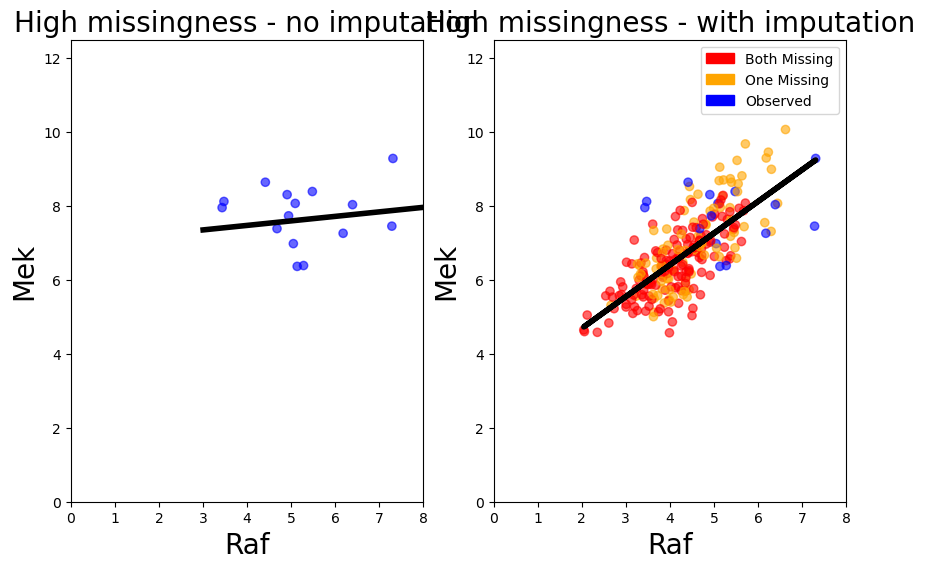

In [16]:
## Plot
fig, ax = plt.subplots(1, 2, figsize=(10,6))


colors2 = np.where((high_missing_protein_data["imp_Mek"] == True) & \
                   (high_missing_protein_data["imp_Raf"] == True), "Red", 
                  np.where((high_missing_protein_data["imp_Raf"] == True) | \
                           (high_missing_protein_data["imp_Mek"] == True), "Orange", "Blue"))


ax[0].scatter(high_missing_protein_data["Raf"], high_missing_protein_data["Mek"], 
              c=colors2, alpha=.6)
ax[0].plot(np.arange(3,9), 
           high_missing_lm.coef_[0]*np.arange(3,9) + high_missing_lm.intercept_[0], 
           color="black", lw=4)

ax[1].scatter(high_missing_protein_data["full_Raf"], high_missing_protein_data["full_Mek"], 
              c=colors2, alpha=.6)
ax[1].plot(high_missing_protein_data["full_Raf"], 
           high_missing_imp_lm.coef_[0]*high_missing_protein_data["full_Raf"] + high_missing_imp_lm.intercept_[0], 
           color="black", lw=4)

red_patch = mpatches.Patch(color='red', label='Both Missing')
orange_patch = mpatches.Patch(color='orange', label='One Missing')
blue_patch = mpatches.Patch(color='blue', label='Observed')

ax[1].legend(handles=[red_patch, orange_patch, blue_patch])

ax[1].set_xlim(0,8)
ax[0].set_xlim(0,8)
ax[1].set_ylim(0,12.5)
ax[0].set_ylim(0,12.5)

ax[1].set_title("High missingness - with imputation", size=20)
ax[0].set_title("High missingness - no imputation", size=20)

# ax[0,0].set_xlabel("Raf")
# ax[0,1].set_xlabel("Raf")
ax[1].set_xlabel("Raf", size=20)
ax[0].set_xlabel("Raf", size=20)

ax[0].set_ylabel("Mek", size=20)
ax[1].set_ylabel("Mek", size=20)

In [17]:
high_missing_protein_data.loc[:, "Mek_std"] = np.nan
high_missing_protein_data.loc[:, "Raf_std"] = np.nan
high_missing_protein_data.loc[high_missing_protein_data["imp_Mek"], "Mek_std"] = mek_std
high_missing_protein_data.loc[high_missing_protein_data["imp_Raf"], "Raf_std"] = raf_std

In [18]:
high_missing_protein_data

,originalRUN,Akt,EGF,Erk,IGF,Mek,PI3K,Raf,Ras,SOS,imp_Mek,imp_Raf,full_Mek,full_Raf,Mek_std,Raf_std
0,0_Obs,23.969979,23.609577,11.254368,20.276095,NaN,31.478477,NaN,16.526868,20.769053,True,True,6.636600,5.009215,0.736649,0.767241
1,1_Obs,20.685256,19.517891,10.179550,16.983482,NaN,25.695139,NaN,11.948731,15.923720,True,True,5.577643,2.851124,0.739497,0.786743
2,10_Obs,18.480347,18.749568,11.830878,15.144268,NaN,22.944948,NaN,12.571201,15.287207,True,True,6.764249,4.502989,0.711214,0.743253
3,100_Obs,19.260349,23.966830,10.909404,16.419784,6.385109,25.382946,NaN,11.434613,NaN,False,True,6.385109,3.317856,NaN,0.741746
4,101_Obs,18.822550,14.274101,9.479468,NaN,NaN,20.049100,NaN,10.044909,11.676932,True,True,5.050595,2.122465,0.706354,0.833650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,221_Obs,NaN,17.279474,NaN,17.092482,5.603125,24.206758,NaN,13.431031,14.168043,False,True,5.603125,4.305103,NaN,0.817386
246,248_Obs,NaN,15.877285,11.002502,NaN,NaN,21.091752,NaN,9.789191,11.151333,True,True,5.947886,2.883149,0.741620,0.912781
247,59_Obs,NaN,17.229154,13.237483,NaN,NaN,24.058757,NaN,12.687029,14.571370,True,True,7.426697,4.519221,0.719706,0.860905
248,69_Obs,NaN,18.473332,NaN,18.390300,NaN,26.435185,NaN,13.877995,NaN,True,True,6.717400,4.405680,1.165063,0.929886


(0.6, 1.3)

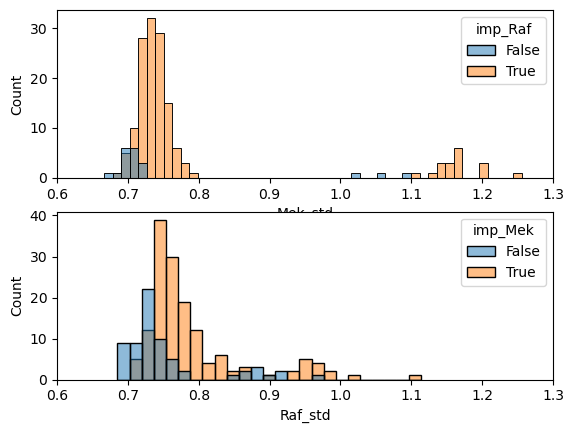

In [36]:
fig, ax = plt.subplots(2,1)
sns.histplot(data=high_missing_protein_data, x="Mek_std", hue="imp_Raf", ax=ax[0])
sns.histplot(data=high_missing_protein_data, x="Raf_std", hue="imp_Mek", ax=ax[1])
ax[0].set_xlim(.6,1.3)
ax[1].set_xlim(.6,1.3)

In [33]:
high_missing_protein_data.head()

,originalRUN,Akt,EGF,Erk,IGF,Mek,PI3K,Raf,Ras,SOS,...,imp_Raf,full_Mek,full_Raf,Mek_std,Raf_std,True_Raf,True_Mek,Raf_error,Mek_error,missing_count
0,0_Obs,23.969979,23.609577,11.254368,20.276095,NaN,31.478477,NaN,16.526868,20.769053,...,True,6.636600,5.009215,0.736649,0.767241,5.338703,7.090611,0.329488,0.454011,NaN
1,1_Obs,20.685256,19.517891,10.179550,16.983482,NaN,25.695139,NaN,11.948731,15.923720,...,True,5.577643,2.851124,0.739497,0.786743,2.631990,6.393248,0.219134,0.815605,NaN
2,10_Obs,18.480347,18.749568,11.830878,15.144268,NaN,22.944948,NaN,12.571201,15.287207,...,True,6.764249,4.502989,0.711214,0.743253,5.091677,7.752938,0.588688,0.988688,NaN
3,100_Obs,19.260349,23.966830,10.909404,16.419784,6.385109,25.382946,NaN,11.434613,NaN,...,True,6.385109,3.317856,NaN,0.741746,4.670147,5.111105,1.352291,1.274004,NaN
4,101_Obs,18.822550,14.274101,9.479468,NaN,NaN,20.049100,NaN,10.044909,11.676932,...,True,5.050595,2.122465,0.706354,0.833650,3.639944,6.598965,1.517480,1.548370,NaN


<Axes: xlabel='Raf_error', ylabel='Count'>

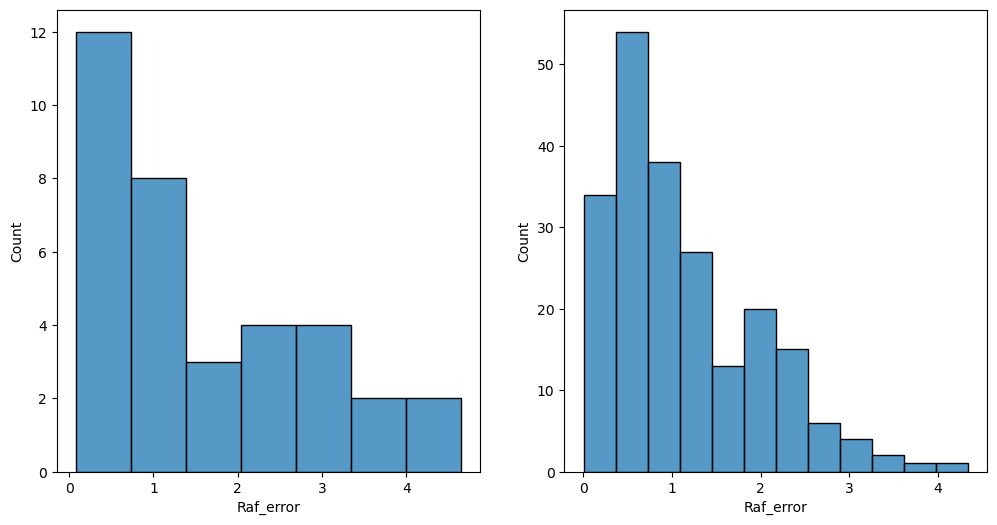

In [49]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
sns.histplot(data=high_missing_protein_data[-high_missing_protein_data["imp_Raf"]], x="Raf_error", ax=ax[0])
sns.histplot(data=high_missing_protein_data[high_missing_protein_data["imp_Raf"]], x="Raf_error", ax=ax[1])

<Axes: xlabel='Mek_error', ylabel='Count'>

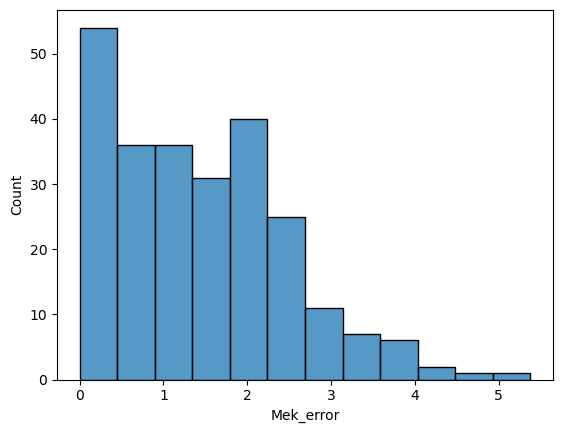

In [46]:
fig, ax = plt.subplots()
sns.histplot(data=high_missing_protein_data, x="Mek_error")

In [20]:
high_missing_protein_data.loc[:, "True_Raf"] = high_missing_data["Protein_data"]["Raf"]
high_missing_protein_data.loc[:, "True_Mek"] = high_missing_data["Protein_data"]["Mek"]

(0.0, 4.5)

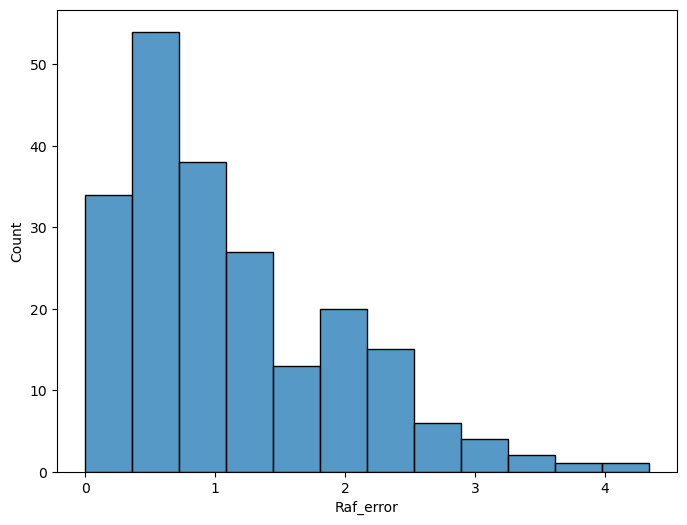

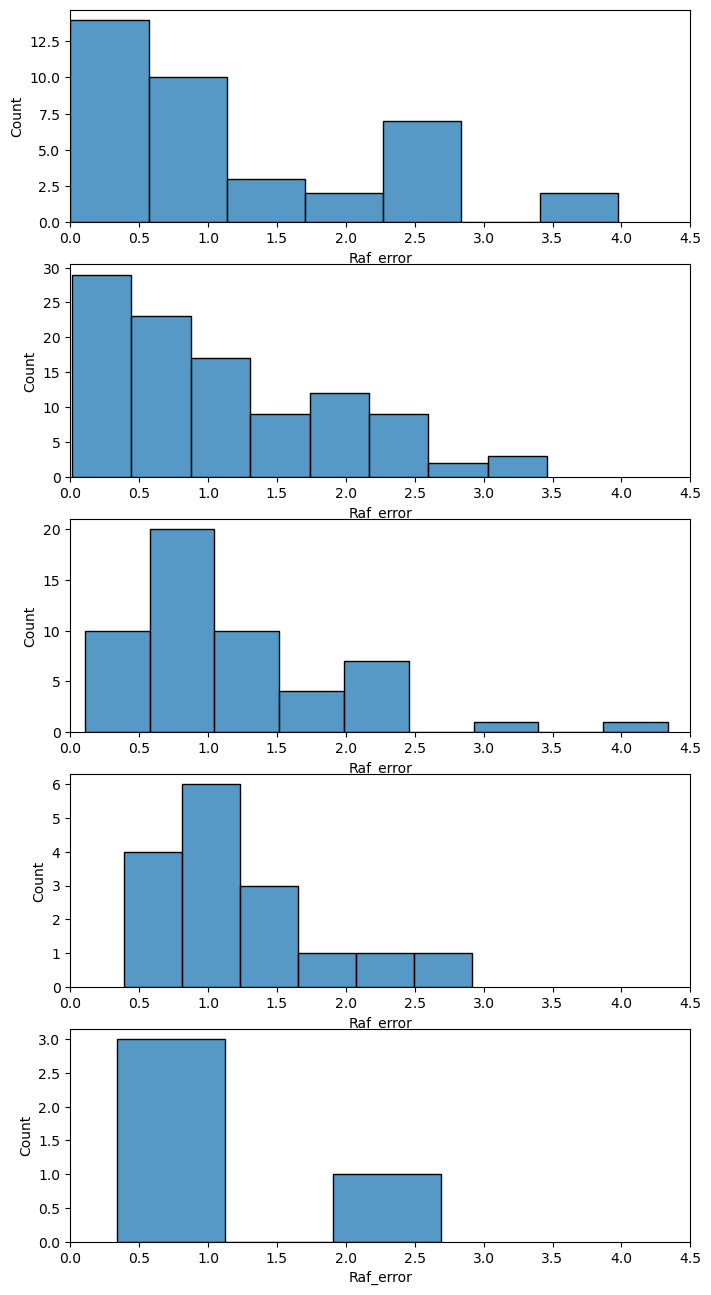

In [44]:
high_missing_protein_data.loc[:, "Raf_error"] = abs(high_missing_protein_data.loc[:, "True_Raf"] - high_missing_protein_data.loc[:, "full_Raf"])

high_missing_protein_data.loc[:, "missing_count"] = high_missing_protein_data.loc[:, ["Akt", "EGF", "Erk", "IGF", 
                                                                                     "Mek", "PI3K", "Raf", "Ras", "SOS"]].isna().sum(axis=1).values

fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(data=high_missing_protein_data[high_missing_protein_data["imp_Raf"]], x="Raf_error", ax=ax)

fig, ax = plt.subplots(5,1, figsize=(8,16))
sns.histplot(data=high_missing_protein_data[(high_missing_protein_data["imp_Raf"]) & 
                                           (high_missing_protein_data["missing_count"] == 1)], x="Raf_error", ax=ax[0])
sns.histplot(data=high_missing_protein_data[(high_missing_protein_data["imp_Raf"]) & 
                                           (high_missing_protein_data["missing_count"] == 2)], x="Raf_error", ax=ax[1])
sns.histplot(data=high_missing_protein_data[(high_missing_protein_data["imp_Raf"]) & 
                                           (high_missing_protein_data["missing_count"] == 3)], x="Raf_error", ax=ax[2])
sns.histplot(data=high_missing_protein_data[(high_missing_protein_data["imp_Raf"]) & 
                                           (high_missing_protein_data["missing_count"] == 4)], x="Raf_error", ax=ax[3])
sns.histplot(data=high_missing_protein_data[(high_missing_protein_data["imp_Raf"]) & 
                                           (high_missing_protein_data["missing_count"] == 5)], x="Raf_error", ax=ax[4])
ax[0].set_xlim(0,4.5)
ax[1].set_xlim(0,4.5)
ax[2].set_xlim(0,4.5)
ax[3].set_xlim(0,4.5)
ax[4].set_xlim(0,4.5)

<Axes: xlabel='Mek_error', ylabel='Count'>

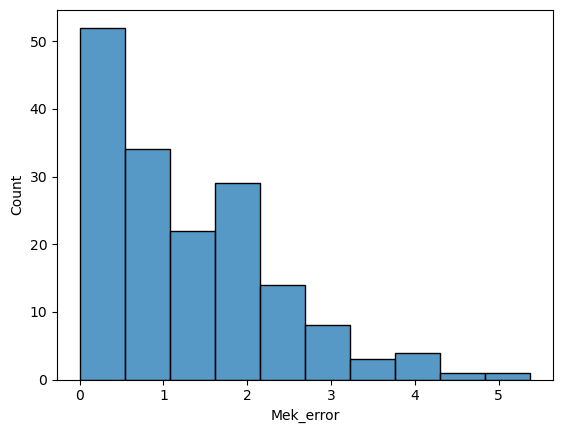

In [25]:
high_missing_protein_data.loc[:, "Mek_error"] = abs(high_missing_protein_data.loc[:, "True_Mek"] - high_missing_protein_data.loc[:, "full_Mek"])

fig, ax = plt.subplots()
sns.histplot(data=high_missing_protein_data[high_missing_protein_data["imp_Mek"]], x="Mek_error")